In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import librosa as lb
import IPython.display as ipd
import scipy.signal as ss
import glob
import os.path
from sklearn import metrics

# Functions #

## Cleaning up audio

In this section, we account for the noise and silence that may occur in the reference and query audios.

For the filterSilence function, we assume that the noise in the background is at a lower volume than the musical phrase in the audio, and we assume that the human vocal range is above a B2 (starting at E2)

For the crop function, we assume that the noise has been removed by the filterSilence function and crop out the frames where there is no energy to eliminate silence. In addition, we remove all energy past the first harmonic since we are only interested in the fundamental frequency. We do this by assuming the first instance where there is energy is a sung note rather than noise, and simply zero out all elements an octave past that instance of energy.

In [3]:
def filterSilence(S, sr, fft_size):
    """ 
   Inputs:
       S -- input unmodified CQT or log frequency spectrogram from STFT
       sr -- sampling rate in samples per second
       fft_size -- window size that was used in computing STFT or CQT
    Outputs:
        S_filter -- filtered CQT or log frequency spectrogram with indices that are likely to be noise set to 0
    """
    S_filter = np.copy(S)
    row, col = S.shape[0], S.shape[1]
    
    # Set threshold as a small fraction of the maximum energy
    maxS = np.amax(S)
    S_filter = np.where(S_filter < maxS * .005, 0, S_filter)
    
    # Since the human vocal range doesn't go below this K index, assume everything in this region is noise
    threshold = 14
    S_filter[:threshold] = 0
    
    return S_filter

In [4]:
def crop(traj, S_filter, CQT = False):
    """
    Inputs: 
        S_filter -- log frequency spectrogram with noise filtered out
        traj -- array specifying the maximum energy at each frame of S_filter
    Outputs:
        S_crop -- STFT where all frames with zero energy in S_filter are deleted
        traj -- new cropped trajectory with all frames of zero energy deleted
    """
    num_frames = traj.shape[0]
    i = 0
    S_crop = np.copy(S_filter)
    
    #Get rid of silence
    while i < (num_frames-1):
        if (S_crop[traj[i], i] <= 0):
            S_crop = np.delete(S_crop, i, 1)
            traj = np.delete(traj, i, 0)
            num_frames -= 1
        else:
            i += 1
    
    num_notes = S_filter.shape[0]
    
    #Get rid of everything past first harmonic for log-frequency spectrogram that was generated by STFT
    if CQT == False:
        for j in range(num_frames-1):
            i = 0
            while i < (num_notes-1):
                if S_crop[i, j] > 0:
                    S_crop[i+10:, j] = 0
                    break
                else:
                    i += 1

    return traj, S_crop

## Time stretch to match lengths of audio ##

In this section, we use the phase vocoder (since we are dealing with voice rather than percussion) to stretch/shrink query audios to be the same length as the reference audio for a more fair comparison and to avoid errors in DTW.
Our main function is tsm_phase_vocoder() which has the helper functions of calc_full_stft(), signal_reconstruction(), and calc_sum_squared_window().

Note: we attribute the function calc_sum_squared_audio to Professor Tsai.

In [5]:
def calc_full_stft(x, L, H_a):
    '''
    Arguments:
        x -- audio data in time domain 
        L -- stft window size
        H_a -- analysis hop size in samples
    Outputs:
        S -- the computed full STFT including the complex conjugates
    '''
    S_half = lb.stft(x, L, H_a) #each column corresponds to an fft analysis frame
    S_conj = np.conj(S_half[1:-1])
    S = np.concatenate((S_half, np.flipud(S_conj)), axis=0)
    
    return S

In [6]:
def signal_reconstruction(num_frames, H_s, L, S_mod):
    '''
    Arguments:
        num_frames -- integer specifiying the number of frames splitting the STFT
        H_s -- synthesis hop size in samples
        L -- integer specifying the length of a frame
        S_mod -- modified STFT we want to reconstruct the time domain audio from
    Outputs:
        x_tsm -- reconstructed audio data
    
    '''
    
    x_tsm = np.zeros(np.int(H_s * num_frames + L)) # instantiate to the length of the output audio
    
    for i in range(num_frames):
        start_s = np.int(i * H_s)
        end_s = np.int(start_s + L)
        hann_window = ss.hann(L)
        # calculate the inverse fft of each column, then multiply by the hann window and divide by the sum of windows squared
        # add above calculated array to the appropriate offset in x_tsm
        x_tsm[start_s: end_s] += (np.real(numpy.fft.ifft(S_mod[:, i]) * hann_window))/calc_sum_squared_window(hann_window, H_s)
    return x_tsm

In [7]:
def principal(radians):
    '''
    Arugments: 
        radians -- a matrix of numbers in radians
        
    Outputs:
        mod -- the input array with each element bounded from -pi to pi
    '''
    mod = np.zeros((radians.shape))
    mod = radians % (2 * np.pi)

    # Find indices of numbers in the lower half of the unit circle and subtract 2pi 
    x = np.where(mod > np.pi)
    mod[x] -= 2 * np.pi
    return mod 

In [8]:
def calc_sum_squared_window(window, hop_length):
    '''
    Calculates the denominator term for computing synthesis frames. 
    
    Inputs: 
    window: array specifying the window used in FFT analysis
    hop_length: the synthesis hop size in samples
    
    Returns an array specifying the normalization factor.
    '''
    
    assert(len(window) % hop_length == 0) #hop length does not divide the window evenly
    numShifts = np.int(len(window) // hop_length)
    den = np.zeros_like(window)
    
    for i in range(numShifts):
        den += np.roll(np.square(window), i*np.int(hop_length))
        
    return den

In [9]:
def estimateIF(S, sr, hop_seconds):
    """
    Arguments:
        S -- input STFT
        sr -- sampling rate
        hop_seconds -- hop size in seconds
    Outputs:
        f_if -- array of estimated instantaneous frequencies
    """
    
    # Find nominal frequency
    k_index = np.arange(S.shape[0])
    f_k = (k_index * sr) / 2048
    w_nom = f_k * 2 * np.pi
    
    # Find phi2 and phi1 and store difference in a matrix
    phase = np.angle(S)
    difference = np.diff(phase)
    
    # Plug into equation to find estimated instantaneous frequency in hertz
    w = (difference - (w_nom * hop_seconds).reshape((-1, 1)))
    f_if = w_nom.reshape((-1, 1)) + (principal(w) / hop_seconds)
    f_if = f_if/(2 * np.pi)
    return f_if

In [10]:
def tsm_phase_vocoder(x, alpha = 1, L = 2048, sr = 22050):
    """
    Takes in audio data (preferably for harmonics audiO) and outputs the data time stretched by alpha 
    Arguments:
        x -- an array of audio data
        alpha -- integer that specifies time stretch factor
        L -- integer that specifies frame length
    Outputs:
        x_tsm -- array of time stretched audio data"""
    H_s = L/4
    H_a = np.int(H_s/alpha)
    
    S = calc_full_stft(x, L, H_a)
    
    #taking magnitude and phase of STFT
    S_mag = np.abs(S)
    S_phase = np.angle(S)
    
    #converting hop size from samples to seconds
    hop_seconds = H_a/sr
    f_if = estimateIF(S, sr, hop_seconds)

    # convert estimated_if from frequency to radians
    w_if = np.pi * 2 * f_if
    
    #modifying the STFT phase
    num_frames = S.shape[1] - 1 #because estimate_if produces a matrix with one less column than S
    num_DFT_bins = S.shape[0]
    S_mod_phase = np.zeros((num_DFT_bins, num_frames))
    S_mod_phase[:, 0] = S_phase[:, 0]  # initialize modified phase
    
    # modify STFT using estimated_if to ensure horizontal phase continuity
    for i in range(1, num_frames):
        S_mod_phase[:, i] = S_mod_phase[:, i-1] + (w_if[:, i-1] * H_s)/sr
    
    #bringing the magnitude and modified phase together
    S_mod = S_mag[:, 0 : num_frames] * np.exp(S_mod_phase * 1j)
    
    # Reconstruct audio using modified STFT
    x_tsm = signal_reconstruction(num_frames, H_s, L, S_mod)
    
    return x_tsm

## Calculate Log Freq ##

In this section, we compute a log frequency spectrogram with improved frequency resolution at lower frequencies. This is important because some of our audio data has some energy at lower frequencies. Our main function calcLogFreqSpec() calls on the helper functions:
- estimateIF() which computes the estimated instantaneous frequencies for each cell of the STFT, and 
- Bin() which computes the bin that a certain frequency belongs in.

In [11]:
def Bin(f, R, f_ref = 32.703, b_ref = 0):
    '''
    Calculates the bins that each entry in an array of frequencies belongs to

    Arguments: 
        f -- an array of frequencies in Hz for which the bins will be calculated 
        R -- resolution in cents per bin 
        f_ref -- the frequency of the lowest bin (default is 32.70 Hz) 
        b_ref -- the bin associated with fref (default is 0)

    Returns: 
        BinF -- a matrix that logs the bins that each entry of f corresponds to
    '''
    BinF = np.round( (1200/R) * (np.log2(np.clip(f, 1e-9, np.max(f))/f_ref) + b_ref) ).astype(int)

    return BinF

In [12]:
def calcLogFreqSpec(S, f_if, fmin = 32.703, R = 100, numOctaves = 7):
    '''
    Computes a refined log frequency spectogram that uses a matrix of instantaneous frequencies. 
    
    Arguments:
        S -- STFT matrix which has dimensions of number of DFT indices X number of frames
        f_if -- number of DFT indices X number of frames matrix of instantaneous frequency estimates of S
        fmin -- minimum frequency in Hz
        R -- resolution in cents per bin 
        numOctaves -- number of octaves to consider
        
    Returns:
        S_lf -- log-frequency spectogram that uses instantaneous frequencies and R (which increases frequency resolution)
    '''
    numNotesPerOctave = 1200/R    
    num_bins = int((numOctaves * numNotesPerOctave) + 1)
    num_frames = f_if.shape[1] #note that this does not include the last column of S
    
    #computing the bins for all the instantaneous frequencies
    Binf_if = Bin(f_if, R)
    
    S_lf = np.zeros((num_bins, num_frames))
    Smag_square = np.square(np.abs(S))[:, :-1]   
    
    num_ks = f_if.shape[0]        
    for b in range(num_bins):
        P = np.where(Binf_if == b, 1, 0)
        S_lf[b] = np.sum(P * Smag_square, axis = 0) #summing the energies from the dft bins that contribute to bin b
        
    return S_lf

## Compute Chroma ##

In this section, we have functions that compute the chroma feature vector matrix:

- computeChroma() computes a 12/24 bin chroma feature vector matrix for a given audio and it calls the helper functions normL2() and chroma(). We collapse across every two octaves to get the chroma feature as opposed to one for the 24 bin chroma feature vector matrix.

Note: normL2() is attributed to Professor Tsai.

In [13]:
def chroma(S, chroma_bins):
    """
    Inputs:
        S -- modified (filtered and cropped) STFT 
        numBinsPerFeatureVector -- the number of rows in the outputted chroma feature vector matrix
        
    Outputs: 
        Chroma -- a chroma feature vector matrix with the dimensions numBinsPerFeatureVector x number of frames 
    """
    row, col = S.shape[0], S.shape[1]
    Chroma = np.zeros((chroma_bins, col))
    for j in range(row):
        Chroma[j % chroma_bins, : ] += S[j, :]
    return Chroma

In [14]:
def normL2(C):
    '''
    Normalize each column of a matrix to have unit L2 norm.
    
    Arguments:
    C -- input feature matrix where each column corresponds to a single feature vector
    
    Returns:
    Fnorm -- normalized feature matrix of the same shape as F, where each column has been
             been normalized to be unit L2 norm
    '''
    norm_factor = np.sqrt(np.sum(C * C, axis = 0))
    Cnorm = C / (norm_factor + 1e-9)
    return Cnorm

In [15]:
def computeChroma(audio, sr, fft_size, hop_samples, f_ref, R, chroma_bins, alpha = None, stretch = False): 
    """
    Inputs: 
        audio -- the time domain representation of audio data
        sr -- sampling rate in samples per second
        fft_size -- the size of an analysis window in STFT computation 
        hop_samples -- the number of samples between frames in the STFT
        f_ref -- the frequency of the lowest frequency bin for our modified STFT
        R -- the frequency resoluttion in cents per bin (used to determine the number of bins to detect per octave)
        chroma_bins -- the number of bins to use for the chroma feature vector matrix
        alpha -- time-stretching factor to be used on query audio in order for it to match reference audio in length
        stretch -- boolean indicating whether or not audio should be stretched (only query audio will be stretched)
        
    Outputs:
        S_logfreq -- log frequency spectogram matrix
        Chroma_norm -- L2 normed chroma feature vector matrix
        traj-chroma -- predicted trajectory of the fundamental frequency in the chroma feature vector matrix
    """    
    # if the audio is a query (not a reference), stretch the audio
    if stretch == True:
        audio = tsm_phase_vocoder(audio, alpha, fft_size, sr)
        
    # compute STFT
    S = lb.core.stft(audio, n_fft = fft_size, hop_length = hop_samples)
    
    # Estimate instantaneous frequency for each cell of the STFT
    f_if = estimateIF(S, sr, hop_samples)
    
    # Compute log frequency spectogram using estimated instantaneous frequencies so that lower frequencies have higher resolution
    S_logfreq = calcLogFreqSpec(S, f_if)
    
    # compute trajectory for log frequency spectrogram 
    traj_logfreq = np.argmax(np.abs(S_logfreq), axis=0)
    
    # filter out noise and crop silence from log frequency spectgram 
    S_filter = filterSilence(S_logfreq, sr, fft_size)
    traj_crop, S_filterCrop = crop(traj_logfreq, S_filter)

    # compute Chroma feature vector matrix, the Chroma's L2 norm and predicted trajectory of fundamental frequency
    Chroma = chroma(S_filterCrop, chroma_bins)
    Chroma_norm = normL2(Chroma)
    traj_chroma = np.argmax(Chroma, axis = 0)
    
    return S_logfreq, S_filter, S_filterCrop, Chroma_norm, traj_chroma

In [16]:
def computeChromaCQT(audio, sr, fft_size, hop_samples, f_ref, R, chroma_bins, alpha = None, stretch = False): 
    """
    Inputs: 
        audio -- the time domain representation of audio data
        sr -- sampling rate in samples per second
        fft_size -- the size of an analysis window in STFT computation 
        hop_samples -- the number of samples between frames in the STFT
        f_ref -- the frequency of the lowest frequency bin for our modified STFT
        R -- the frequency resoluttion in cents per bin (used to determine the number of bins to detect per octave)
        chroma_bins -- the number of bins to use for the chroma feature vector matrix
        alpha -- time-stretching factor to be used on query audio in order for it to match reference audio in length
        stretch -- boolean indicating whether or not audio should be stretched (only query audio will be stretched)
        
    Outputs:
        S_logfreq -- log frequency spectogram matrix
        Chroma_norm -- L2 normed chroma feature vector matrix
        traj-chroma -- predicted trajectory of the fundamental frequency in the chroma feature vector matrix
        CQT -- constant Q transform for the audio data
        CQT_filter -- filtered constant Q transform 
        CQT_filterCrop -- filtered and cropped constant Q transform 
        Chroma_normfilter -- filtered and normed chroma from the CQT
        traj_chroma -- trajectory of the predicted fundamental frequency in the chroma
    """   
    
    # if the audio is a query (not a reference), stretch the audio
    if stretch == True:
        audio = tsm_phase_vocoder(audio, alpha, fft_size, sr)
    
    # compute CQT and trajectory in the CQT
    CQT =  np.abs(lb.cqt(audio, hop_length = hop_samples, n_bins = 85))
    traj_CQT = np.argmax(np.abs(CQT), axis=0)
    
    # filter and crop CQT
    CQT_filter = filterSilence(CQT, sr, fft_size)
    traj_crop, CQT_filterCrop = crop(traj_CQT, CQT_filter, CQT = True)
    
    # compute chroma and normalize and compute a trajectory for the chroma
    Chroma = chroma(CQT_filterCrop, chroma_bins)
    Chroma_norm = normL2(Chroma)
    traj_chroma = np.argmax(Chroma, axis = 0)
    
    # Because harmonic were not removed in the earlier phase of CQT, remove the harmonics on the chroma
    Chroma_normfilter = filterChromaCQT(Chroma_norm, traj_chroma)
    
    return CQT, CQT_filter, CQT_filterCrop, Chroma_normfilter, traj_chroma

In [17]:
def filterChromaCQT(Chroma_norm, traj_chroma):
    """
    Inputs: 
        Chroma_norm -- normalized chroma feature vector matrix (this will only be called on chroma computed from CQT)
        traj_chroma -- trajectory through the Chroma
    Outputs:
        newChroma -- Chroma that has been filtered to cut out harmonics
    
    """
    newChroma = np.zeros_like(Chroma_norm)
    for i in range(len(traj_chroma)):
        newChroma[traj_chroma[i] - 2:traj_chroma[i] + 2, i] = Chroma_norm[traj_chroma[i] - 2 : traj_chroma[i] + 2, i]
    return newChroma

## DTW ##

We use DTW since we want to allow for queries with longer/shorter notes to still be accepted as a match as long as the interval structure is a close enough match.

In this section, we using dynamic time warping to compute a match score between a query and reference audio:
- DTW() takes in a query and reference as well as steps and weights and outputs the lowest cost from dynamic time warping using a transposed query and the reference audio
- computeCostMatrix_costdist() is a helper function for DTW() that takes in two feature vector matrices and computes their cos distance.

In [18]:
def computeCostMatrix_cosdist(Cquery,Cref):
    """
    Computes the cosine distance cost matrix.
    
    Inputs:
    Cquery -- the normalized chroma for query audio
    Cref -- the normalized chroma feature matrix for audio
    
    Outputs:
    C -- cosine distance matrix between the Cquery and Cref
    """
    C = 1 - (Cquery.transpose() @ Cref)
    return C

In [19]:
steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
weights_12 = [1, 1, 1]
weights_24 = [2, 2, 1]

In [20]:
def DTW(Query, Reference, steps, weights, chroma_bins):
    """
    Inputs:
        Query -- norm feature vector matrix of the query (we will be using Chroma feature vectors)
        Reference -- norm feature vector matrix of the reference (we will be using Chroma feature vectors)
        steps -- array specifying the allowed transitions in the cost matrix that will be computed with dimensions of (number of allowable transitions, 2)
        weights -- list of numbers to multiply each cost accumulation by (the lower the weight the more incentivized the corresponding path is)
        chroma_bins -- the number of bins to use for the chroma feature vector matrix

    Outputs:
        best_cost -- the lowest cost from dynamic time warping using a transposed query and the reference audio
        best_transpose -- the transposed query chroma feature vector matrix corresponding to the best_cost
        all_transpose -- a list of all the tranposes of the query feature vector matrices that have been considered (for debugging purposes)
    """

    # the number of transposes of the query to consider when doing the dynamic time warping
    num_transposes = chroma_bins
    
    # initializing the best_cost to an arbitrarily large number
    best_cost = np.inf
    best_index = None
    all_transpose = []
    
    for i in range(num_transposes):
        # take a transpose of the query matrix 
        Query_transposed = np.roll(Query, i, axis = 0)
        
         # compute the cos distance cost matrix between the transposed query and the reference audio
        C = computeCostMatrix_cosdist(Query_transposed, Reference)
        
        # log the transposed query matrix in all_transposes (to be used for debugging purposes)
        all_transpose.append(Query_transposed)
        
        # look for the most optimal path between in the cost distance matrix
        D, wp = lb.sequence.dtw(C = C, step_sizes_sigma = steps, weights_mul = weights, backtrack = True)
        
        # update best_cost and best_index if the optcost is lower than the best_cost so far
        optcost = np.min(D[-1,:])
        if optcost < best_cost:
            best_cost = optcost
            best_index = i
    
    # get the matrix corresponding to the transpose of the query with the lowest cost
    best_transpose = np.roll(Query, best_index, axis = 0)
    
    return best_cost, best_transpose, all_transpose

## Graphing ##

In this section we define the graphing functions that we used in our exploratory analysis:

- plotLogSpec is used to plot a log frequency spectogram and uses the helper function getXLabelsSeconds tp change the x-axis labels to seconds for ease of understanding
- plotChroma is used to plot a 24-note chroma feature vector matrix 
- plotROC is used to 
    - compute the false positive rate, true positive rate for varying thresholds given ground truth annotations and scores for a set of training data, and
    - plot the resulting Receiver Operating Characteristic (ROC) curve
    
Note: the code for plotROC was obtained from the example code on https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [21]:
def getXLabelsSeconds(num_frames, hop_sec):
    '''
    Computes and returns the labels (in terms of seconds) and location of labels on the x-axis.
    
    Arguments:
        num_frames -- the number of frames in the audio being displayed
        hop_sec -- the amount of time in seconds between two consecutive frames in the STFT for the audio
    Returns:
        xTicklabels -- array of the labels to be placed on the x-axis        
        xLoc -- array of the locations along the x-axis at which to place the xTickLabels.
    '''
    # make xTickLabels differ by 2 seconds each time
    xTickLabels = (np.arange(0, num_frames*hop_sec, 2)).astype(int)
    num_xlabels = xTickLabels.shape[0]
    
    # compute the locations along the x-axis at which to place the xTickLabels
    xLoc = np.zeros((num_xlabels))
    for i in range(num_xlabels):
        xLoc[i] = i * 2 / hop_sec
    
    return xLoc, xTickLabels

In [22]:
def plotLogSpec(S, hop_sec, numBinsPerOctave, traj = None, N = 2048):
    '''
    Plots a log frequency spectogram with trajectory overlaid (if given)
    
    Arguments: 
        S -- Log frequency spectogram which has dimensions of number bins X number of frames
        hop_sec -- the amount of time in seconds between two consecutive frames in the STFT for the given audio data
        numBinsPerOctave -- the number of frequency bins in each octave
        traj -- a 1D array of the maximum frequencies in each column 
    '''
    num_bins = S.shape[0] 
    num_frames = S.shape[1] 
    fig, ax = plt.subplots(figsize = (16, 8))
    Sdb = lb.core.amplitude_to_db(abs(S))

    #converting the labels on the x-axis to seconds
    xLoc, xTickLabels = getXLabelsSeconds(num_frames, hop_sec)
    ax.set_xticks(xLoc) #sets location of x ticks
    ax.set_xticklabels(xTickLabels, fontsize = 15) 
    
    #converting the labels on the y-axis to Notes
    numOctaves = int((num_bins/numBinsPerOctave) + 1)
    yTickLabels = []
    for i in range(1, numOctaves+1):
        yTickLabels.append("C" + str(i))
    yLoc = np.arange(numOctaves) * num_bins//(numOctaves-1)
    yLoc[-1] = num_bins-1
    ax.set_yticks(yLoc) #sets location of y ticks
    ax.set_yticklabels(yTickLabels, fontsize = 15)    
    
    #plotting the log frequency spectogram 
    plt.imshow(Sdb, origin='lower', cmap = 'jet',  aspect = 'auto', interpolation = 'nearest')
    plt.title('Log Frequency Spectogram', fontsize = 15)
    plt.xlabel('Time (seconds)', fontsize = 15)
    plt.ylabel('Note', fontsize = 15) 
    
    #overlaying the trajectory
    if (np.all(traj) != None):
        plt.scatter(x = np.arange(traj.shape[0]), y = traj, color = 'red')

In [23]:
def plotChroma(Chroma, hop, binsPerOctave = 12, traj = None):
    """
    Inputs:
        Chroma -- 24 x number of frames matrix of the corresponding to the Chroma feature vectors (two octaves)
        hop -- the number of samples that are between frames in prior STFT computation
        binsPerOctave -- the number of bins that we are considering per octave (frequency resolution)
        traj -- the predicted trajectory of the notes in each frame for the Chroma feature vector matrix 
    """
    num_frames = Chroma.shape[1]
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(Chroma, aspect = "auto", origin = "lower")
    plt.title('Chroma Feature Vector Matrix', fontsize = 15)
    plt.xlabel('Time (seconds)', fontsize = 15)
    plt.ylabel('Chroma bin', fontsize = 15) 
    
    #converting the labels on the x-axis to seconds
    xLoc, xTickLabels = getXLabelsSeconds(num_frames, hop_sec)
    ax.set_xticks(xLoc) #sets location of x ticks
    ax.set_xticklabels(xTickLabels, fontsize = 15) 
    
    if traj is not None:
        ax.scatter(np.arange(Chroma.shape[1]), traj, marker='.', color = 'r')    

In [24]:
def plotROC(labels, scores, pos_label):
    """
    Inputs:
        labels -- array of the ground truth labels of the queries for which best scores were calculated
        scores -- array of scores of query when compared to reference audio
        neg_label -- the label indicating a non-match in the labels list (i.e. if non-matches are indicated with a 0 in the labels, then neg_label will be 0)
        
    Outputs:
        fpr -- array of false positive rates from the roc curve on the training data
        tpr -- array of true positive rates from the roc curve on the training data
        thresholds -- array of the thresholds corresponding to the rates in fpr and tpr
    """
    # Computing false positive rate and true positive rate at certain thresholds
    
    # Note: metrics.roc_curve technically takes in a pos_label (positive label which would correspond to the label indicating a match), 
    # However, metrics.roc_curve() works by assigning the pos_label to a score if it is *above* a certain threshold (maximizing score)
    # Since we are computing costs for our scores and our goal is to minimize cost, a match in our system corresponds to a score *below* 
    # a given threshold. So, we had to pass in the non-matching classification code (0) instead of the matching classification code (1) 
    # to circumvent metrics.roc_curve()
    
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label = pos_label)
    
     # plotting the ROC (Receiver Operating Characteristic) curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    return fpr, tpr, thresholds

## Determine a threshold ##

In this section, we calculate a threshold based on the best costs of the training data vs. the refernces. 

- For calculateScores, we compute the best costs of query audios in the training directory when compared to the reference audios and then compute the average best cost.

- For chooseThreshold, we compute the threshold corresponding to a true positive rate above 80% and a false positive rate below 10%.

In [58]:
def calculateScores(refdir, trainingdir, steps, weights, fft_size, chroma_bins, CQT = False, Energy = False):
    """ 
    Inputs:
        refdir -- the folder that the reference audios are in 
        trainingdir -- the folder that the query audios are in (for the training dataset)
        steps -- array specifying the allowed transitions in the cost matrix that will be computed with dimensions of (number of allowable transitions, 2)
        weights -- list of numbers to multiply each cost accumulation by (the lower the weight the more incentivized the corresponding path is)
        fft_size -- the analysis window-size in samples for the STFT of an audio 
        chroma_bins -- number of chroma features
        CQT -- boolean determining whether to calculate chroma from CQT
        Energy -- boolean determining whether to run DTW on the raw energy of the log freq spec or CQT 
        
    Outputs:
        best_cost_arr -- an array of the best_costs of each query when compared to the reference audios using dynamic time warping
        best_cost_average -- averaged cost between references
        best_cost_max -- maximum cost between references
    """
    
    refLength = len((glob.glob(refdir + '/*.m4a')))
    trainingLength = len((glob.glob(trainingdir + '/*.m4a')))
    best_cost_arr = np.zeros((trainingLength, refLength))
   
    for j in range(refLength):  
        # load in a reference audio and compute its chroma
        reffile = glob.glob(refdir + '/*.m4a')[j]
        xref, sr = lb.core.load(reffile)
        if CQT == False:
            Logr, Filterr, FilterCropr, Chroma_r, traj_chromar = computeChroma(xref, sr, fft_size, hop_samples, f_ref, R, chroma_bins)
        else:
            Logr, Filterr, FilterCropr, Chroma_r, traj_chromar = computeChromaCQT(xref, sr, fft_size, hop_samples, f_ref, R, chroma_bins)
        
        for i in range(trainingLength):
            
             # compute the chroma of the query after time-stretching the query to match the reference in length
            querfile = glob.glob(trainingdir + '/*.m4a')[i]
            xquery, sr = lb.core.load(querfile)
            alpha = xref.shape[0] / xquery.shape[0]
            if CQT == False:
                Logq, Filterq, FilterCropq, Chroma_q, traj_chromaq = computeChroma(xquery, sr, fft_size, hop_samples, f_ref, R, chroma_bins, alpha = alpha, stretch = True)
            else:
                Logq, Filterq, FilterCropq, Chroma_q, traj_chromaq = computeChromaCQT(xquery, sr, fft_size, hop_samples, f_ref, R, chroma_bins, alpha = alpha, stretch = True)
           
            try:
                # compute best_cost for the query vs. the reference audios
                if Energy == True:
                    normq = normL2(FilterCropq)
                    normr = normL2(FilterCropr)
                    best_cost, best_transpose, all_transpose = DTW(normq, normr, steps, weights, chroma_bins)
                    best_cost_arr[i][j]  = best_cost
                    print(best_cost, "query:", querfile)
                else:
                    best_cost, best_transpose, all_transpose = DTW(Chroma_q, Chroma_r, steps, weights, chroma_bins)
                    best_cost_arr[i][j]  = best_cost
                    print(best_cost, "query:", querfile)
            except:
                # if there is an error, it is likely due to a mismatch so set the best_cost to an arbitrarily high value
                best_cost_arr[i][j] = 300
                print("Error")
            
    
 
    best_costs_average = np.sum(best_cost_arr, axis = 1)/refLength
    best_costs_max = np.max(best_cost_arr, axis = 1)

                 
    return best_cost_arr, best_costs_average, best_costs_max

In [26]:
def chooseThreshold(fpr, tpr, thresholds):
    """ 
    Inputs:
        fpr -- array of false positive rates from the roc curve on the training data
        tpr -- array of true positive rates from the roc curve on the training data
        thresholds -- array of the thresholds corresponding to the rates in fpr and tpr
    Outputs:
        threshold -- the threshold corresponding to a true positive rate above 85% and false positive below than 10%
    """
    num_thresholds = thresholds.shape[0]
    for i in range(num_thresholds):
        # return the threshold that maximizes true positive rate and minimizes false positive rate
        if tpr[i] > 0.80 and fpr[i] <= 0.10:
            return thresholds[i]

## Label and determine accuracy ##

In this section, we evaluate the efficacy of our system using runBenchmark which has the helper functions generateLabels and calcAccuracyAndRates.

For the runBenchmark function:

- We get a threshold that maximizes true positive rate and minimizes false positive rate based on the training data using chooseThreshold.
- Then, we generate labels for the query files in the testing data using generateLabels
- Then, we compute average best costs for each of the query files against all of the reference files, and compare it to our chosen threshold. If the average best cost for a query is below the chosen threshold, then we predict a match, and vice versa.
- Then we evaluate the efficacy of the system by comparing our predictions to the ground truth annotations usinc calcAccuracyAndRates

In [27]:
def generateLabels(querydir, grouping):
    """ 
   Inputs:
       querydir -- the folder that the query audios are in
       grouping -- the song/ musical phrase of the reference audios
    Outputs:
        gt_labels -- 1D array representing ground truth labels for the query audios (1 is for match, and 0 is for non-match)
    """
    
    gt_labels = []
    length = len((glob.glob(querydir + '/*.m4a')))
    
    # iterate through the queries
    for i in range(length):
        
        # if the current query corresponds to the song/ musical phrase specified in grouping, write a 1
        if (grouping in (glob.glob(querydir + '/*.m4a'))[i]):
            gt_labels.append(1)   
        
        # if the current query is not a match to the song/musical phrase in grouping, write a 0
        else:
            gt_labels.append(0)
    return gt_labels

In [28]:
def calcAccuracy(gt_labels, pred_labels):
    """ 
    Inputs:
       gt_labels -- 1D array representing ground truth labels for the query audios (1 is for match, and 0 is for non-match)
       pred_labels -- 1D array representing the predicted labels for the query audios 
    Outputs:
        truePos -- the count for the number of correct guesses of matches
        trueNeg -- the count for the number of corrent guesses of non-matches
        falsePos -- the count for the numebr of incorrect guesses of non-matches
        falseNeg -- the count for the number of incorrect guesses of matches
    """
    #initialization
    falsePos = 0
    falseNeg = 0
    trueNeg = 1e-9
    truePos = 1e-9
    num_audio = len(gt_labels)
    
    for i in range(num_audio):
        if (gt_labels[i] == 1):
            if (pred_labels[i] == 1):
                truePos += 1
            else:
                falseNeg += 1
        else:
            if (pred_labels[i] == 0):
                trueNeg += 1
            else:
                falsePos += 1

    return truePos, trueNeg, falsePos, falseNeg

In [29]:
def calcRates(truePos, trueNeg, falsePos, falseNeg):
    """
    Inputs:
        truePos -- the count for the number of correct guesses of matches
        trueNeg -- the count for the number of corrent guesses of non-matches
        falsePos -- the count for the numebr of incorrect guesses of non-matches
        falseNeg -- the count for the number of incorrect guesses of matches
       
    Outputs:
        accuracy -- number of correct predictions/ total number of query files
        f1-score -- similar metric to accuracy that takes into account which portion of our correct and incorrect guesses were for matches vs. non-matches
        falsePosRate -- false positive rate = number of false positives/(number of false positives + number of true negatives)
        falseNegRate -- false negative rate = number of false negatives/(number of false negatives + number of true positives)
    """
    
    # computing false positive and false negative rates
    falsePosRate = falsePos / (falsePos + trueNeg)
    falseNegRate = falseNeg / (falseNeg + truePos)
    
    # computing accuracy
    accuracy = (truePos + trueNeg) / (truePos + trueNeg + falseNeg + falsePos)
    
    # computing f1-score
    precision = truePos / (truePos + falsePos)
    recall = truePos / (truePos + falseNeg)
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    return accuracy, f1, falsePosRate, falseNegRate, 

In [30]:
def runBenchmark(testingdir, refdir, weights, grouping, fpr, tpr, thresholds, chroma_bins, average = True):
    """
    Inputs: 
        testingdir -- the folder that the query audios are in (for the testing dataset)
        refdir -- the folder that the reference audios are in
        weights -- weights to use in dtw
        fpr -- array of false positive rates from the roc curve on the training data
        tpr -- array of true positive rates from the roc curve on the training data
        thresholds -- array of the thresholds corresponding to the rates in fpr and tpr
        grouping -- the song/musical phrase in the reference audios
        chroma_bins -- number of chroma features 
        average -- boolean for whether to use the average best scores or the maximum best scores for each query file in the training dataset
    
    Outputs:
        accuracy -- number of correct predictions/ total number of query files
        falsePosRate -- false positive rate = number of false positives/(number of false positives + number of true negatives)
        falseNegRate -- false negative rate = number of false negatives/(number of false negatives + number of true positives)
    """
    # computing threshold that will be used to classify queries in the testing dataset as matches/non-matches
    threshold = chooseThreshold(fpr, tpr, thresholds)
    gt_labels = generateLabels(testingdir, grouping)
    print(threshold)
    print(gt_labels) 
       
    (correct, total) = (0,0)
    print('Processing ', end='')
    
    refLength = len((glob.glob(refdir + '/*.m4a')))
    testingLength = len((glob.glob(testingdir + '/*.m4a')))
    print(testingLength)
    best_cost_arr = np.zeros((testingLength, refLength))
   
    for j in range(refLength):  
        
        #load in a reference audio and compute its chroma 
        reffile = glob.glob(refdir + '/*.m4a')[j]
        xref, sr = lb.core.load(reffile)
        Logr, Filterr, FilterCropr, Chroma_r, traj_chromar = computeChroma(xref, sr, fft_size, hop_samples, f_ref, R, chroma_bins)
        
        for i in range(testingLength):
            # compute the chroma of the query after time-stretching the query to match the reference in length
            querfile = glob.glob(testingdir + '/*.m4a')[i]
            xquery, sr = lb.core.load(querfile)
            alpha = xref.shape[0] / xquery.shape[0]
            Logq, Filterq, FilterCropq, Chroma_q, traj_chromaq = computeChroma(xquery, sr, fft_size, hop_samples, f_ref, R, chroma_bins, alpha = alpha, stretch = True)
            
            try:
                # compute best_cost for the query vs. the reference audios
                best_cost, best_transpose, all_transpose = DTW(Chroma_q, Chroma_r, steps, weights, chroma_bins)
                best_cost_arr[i][j]  = best_cost
                print(best_cost, "query:", querfile)
            except:
                best_cost_arr[i][j]  = 300
                print("Error", "query:", querfile)
            
    # compute the average best cost of each query (instead of having a best cost for every reference a query is compared to)
    if average == True:
        best_costs = np.sum(best_cost_arr, axis = 1)/refLength
    # compute the maximum best cost of each query (instead of having a best cost for every reference a query is compared to)
    else:
        best_costs = np.max(best_cost_arr, axis = 1)
    

    print(best_costs)
    # generate an array of 1s (match) and 0s (non-match) for the queries
    pred_labels = np.where(best_costs < threshold, 1, 0)
    print(pred_labels)
    
    # compute counts for false positivees, false negatives, true positives and true negatives
    truePos, trueNeg, falsePos, falseNeg = calcAccuracy(gt_labels, pred_labels)
    return truePos, trueNeg, falsePos, falseNeg

# Sample Graphs #

In [33]:
sr = 22050
hop_samples = 128
fft_size = 2048
f_ref = 32.703 # C1
pitch_ref = 24
R = 100
hop_sec = hop_samples / sr
binsPerOctave = 1200 / R

Looking at graphs for some audio using regular STFT

In [35]:
Test, sr = lb.core.load("training/Match FourNotes Piano 0.m4a")
ipd.Audio(Test, rate = sr)

C:\Users\Ruth\Anaconda3\envs\E207_env_lb_test\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [37]:
LogT, FilterT, FilterCropT, Chroma_normT, traj_chromaT = computeChroma(Test, sr, fft_size, hop_samples, f_ref, R, chroma_bins = 12)

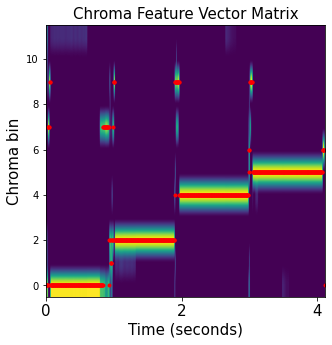

In [40]:
plotChroma(Chroma_normT, hop_samples, traj = traj_chromaT)

### Match Four Notes Cat 0

In [53]:
FourNotes_Cat0, sr = lb.core.load("training/ref/Match FourNotes_Cat_0.m4a")
ipd.Audio(FourNotes_Cat0, rate = sr)

In [54]:
Log0, Filter0, FilterCrop0, Chroma_norm0, traj_chroma0 = computeChroma(FourNotes_Cat0, sr, fft_size, hop_samples, f_ref, R, chroma_bins = 12)
LogCQT0, FilterCQT0, FilterCropCQT0, Chroma_normCQT0, traj_chromaCQT0 = computeChromaCQT(FourNotes_Cat0, sr, fft_size, hop_samples, f_ref, R, chroma_bins = 12)

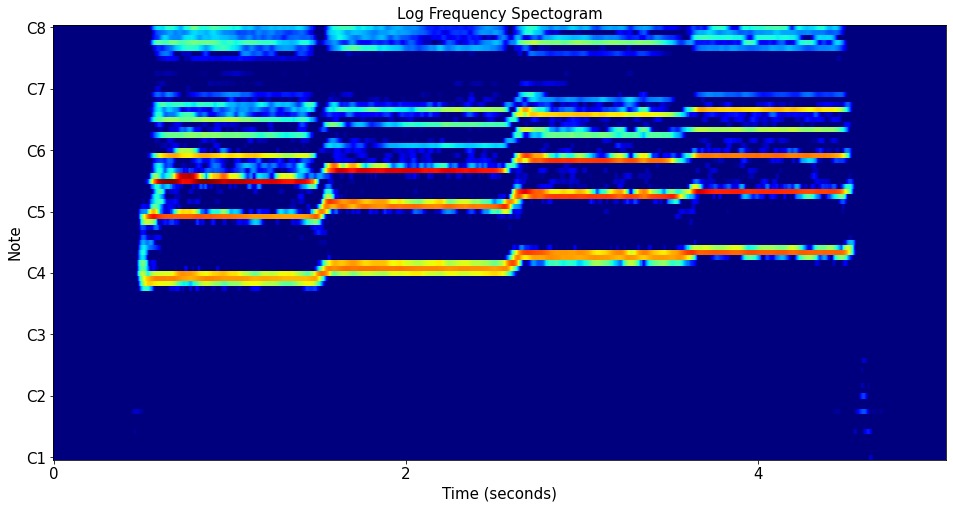

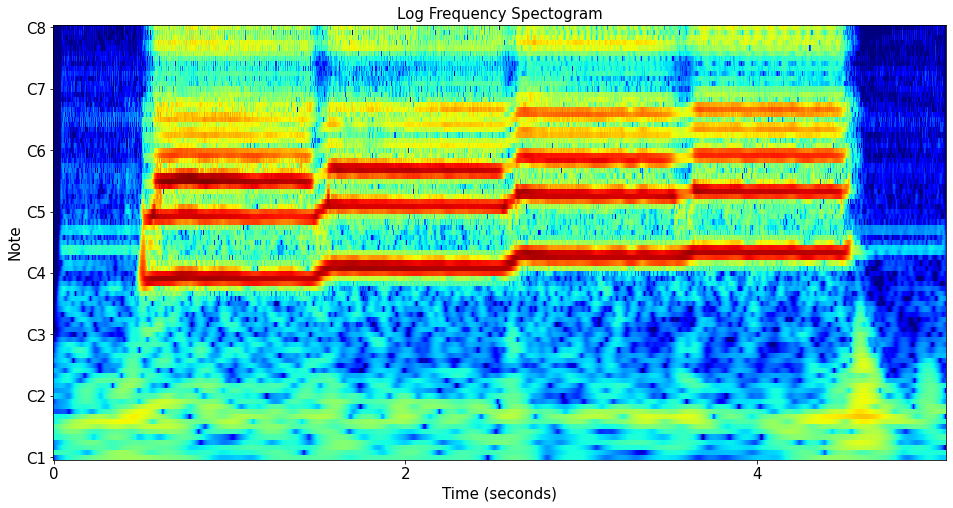

In [55]:
plotLogSpec(Log0, hop_sec, binsPerOctave)
plotLogSpec(LogCQT0, hop_sec, binsPerOctave)

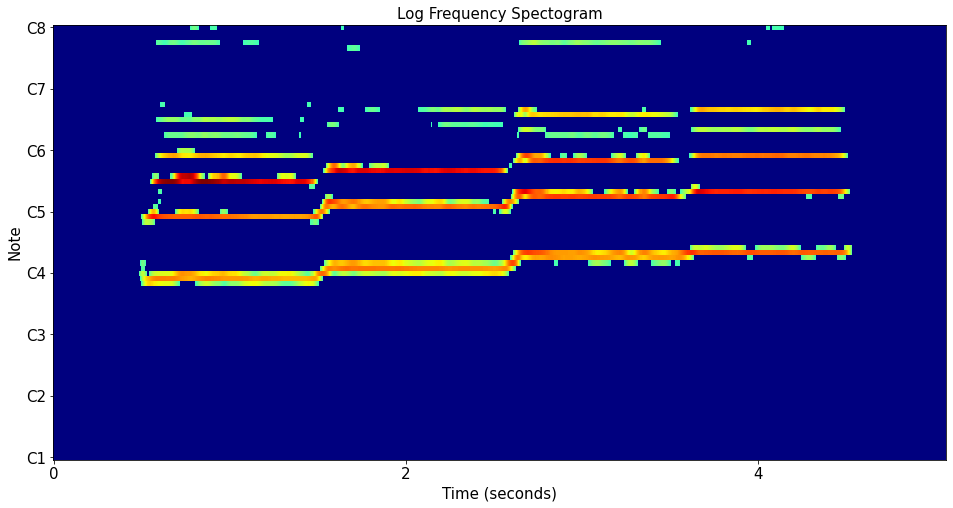

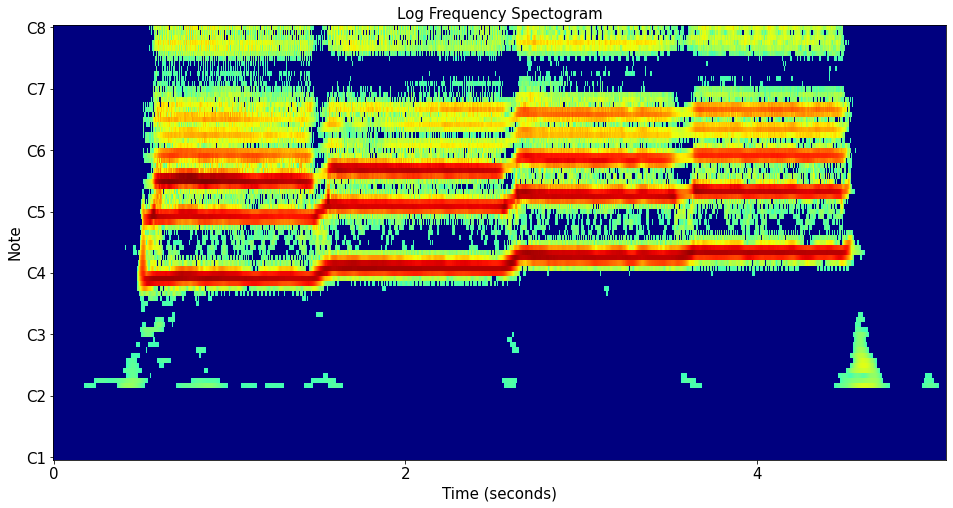

In [56]:
plotLogSpec(Filter0, hop_sec, binsPerOctave)
plotLogSpec(FilterCQT0, hop_sec, binsPerOctave)

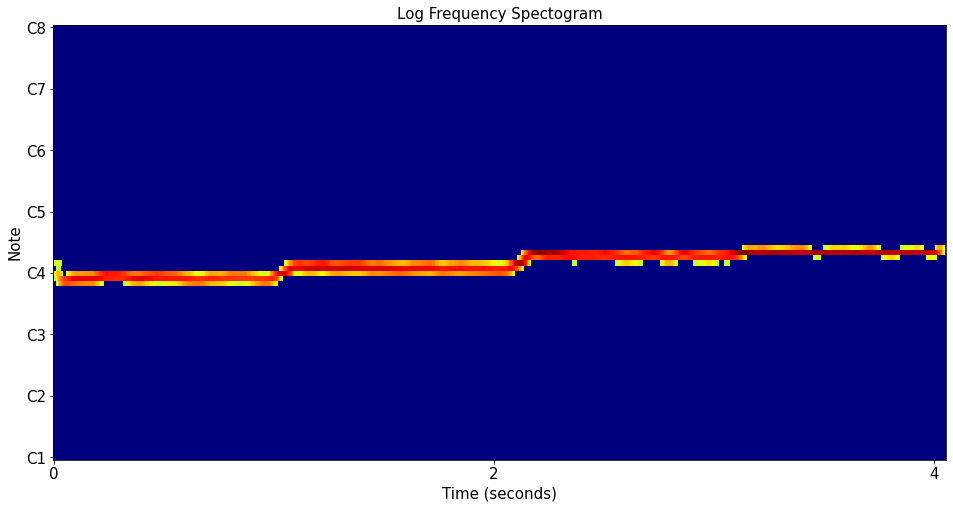

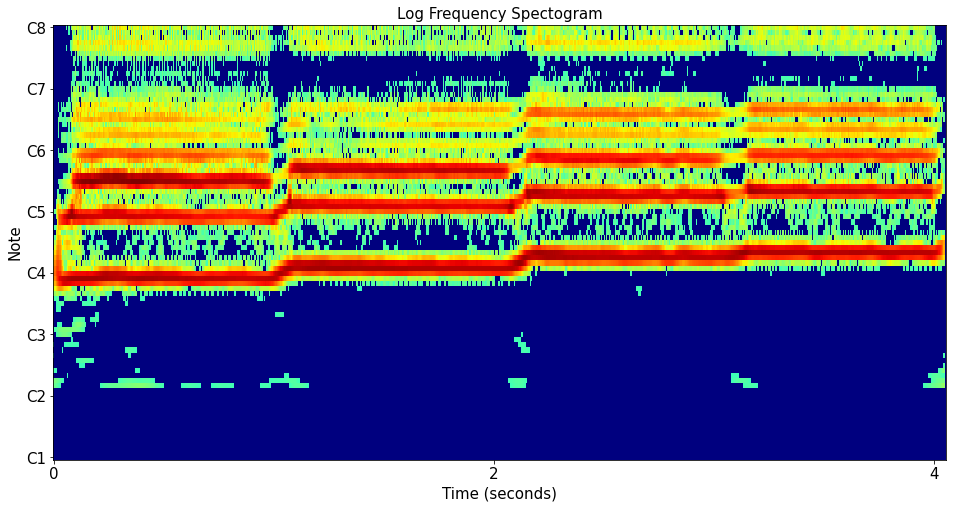

In [57]:
plotLogSpec(FilterCrop0, hop_sec, binsPerOctave)
plotLogSpec(FilterCropCQT0, hop_sec, binsPerOctave)

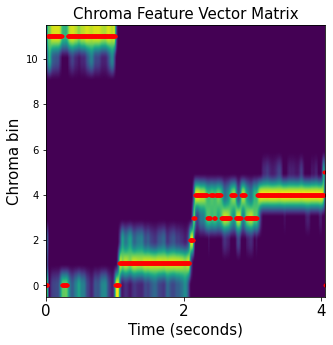

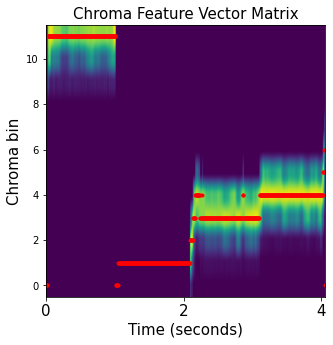

In [58]:
plotChroma(Chroma_norm0, hop_samples, traj = traj_chroma0)
plotChroma(Chroma_normCQT0, hop_samples, traj = traj_chromaCQT0)

### Match MD Ruth 2 ### 

In [59]:
MD_Ruth2, sr = lb.core.load("training/Match MD Ruth 2.m4a")
ipd.Audio(MD_Ruth2, rate = sr)

In [61]:
Log1, Filter1, FilterCrop1, Chroma_norm1, traj_chroma1 = computeChroma(MD_Ruth2, sr, fft_size, hop_samples, f_ref, R, chroma_bins = 12)

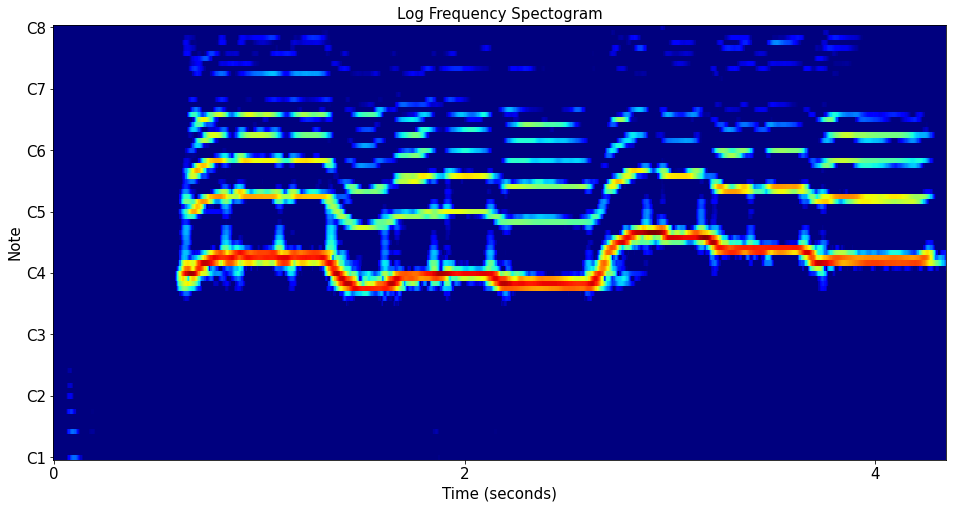

In [62]:
plotLogSpec(Log1, hop_sec, binsPerOctave)

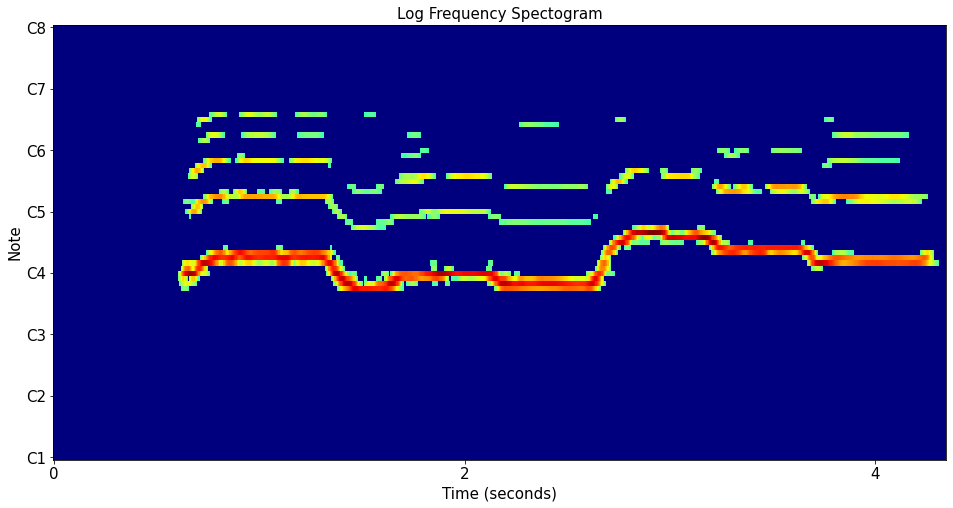

In [63]:
plotLogSpec(Filter1, hop_sec, binsPerOctave)

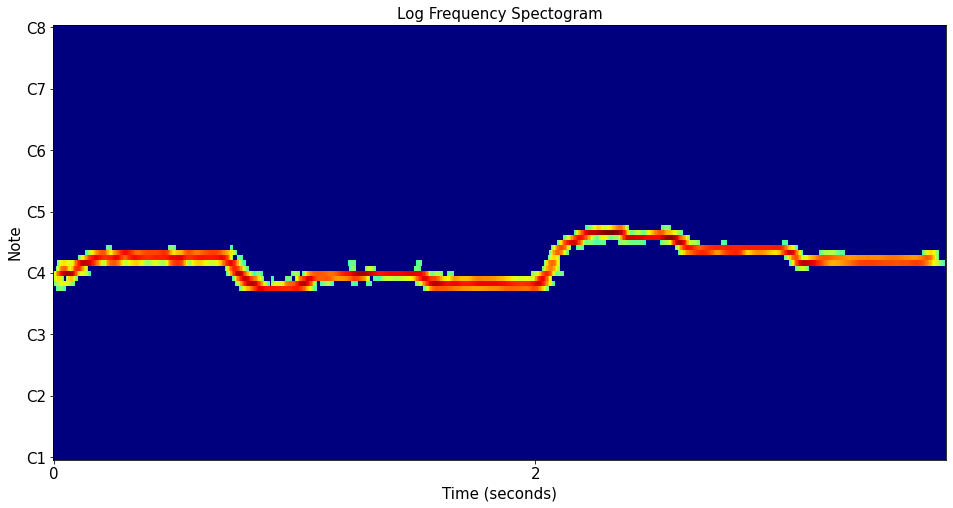

In [64]:
plotLogSpec(FilterCrop1, hop_sec, binsPerOctave)

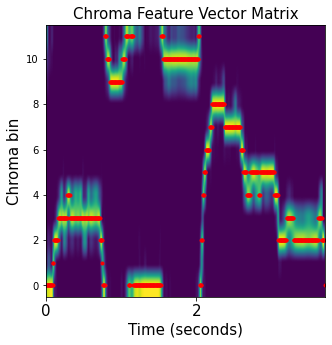

In [65]:
plotChroma(Chroma_norm1, hop_samples, traj = traj_chroma1)

### Match MD Cat 2 ###

In [66]:
MD_Cat2, sr = lb.core.load("training/Match MD Cat 2.m4a")
ipd.Audio(MD_Cat2, rate = sr)

In [67]:
Log2, Filter2, FilterCrop2, Chroma_norm2, traj_chroma2 = computeChroma(MD_Cat2, sr, fft_size, hop_samples, f_ref, R, 24)

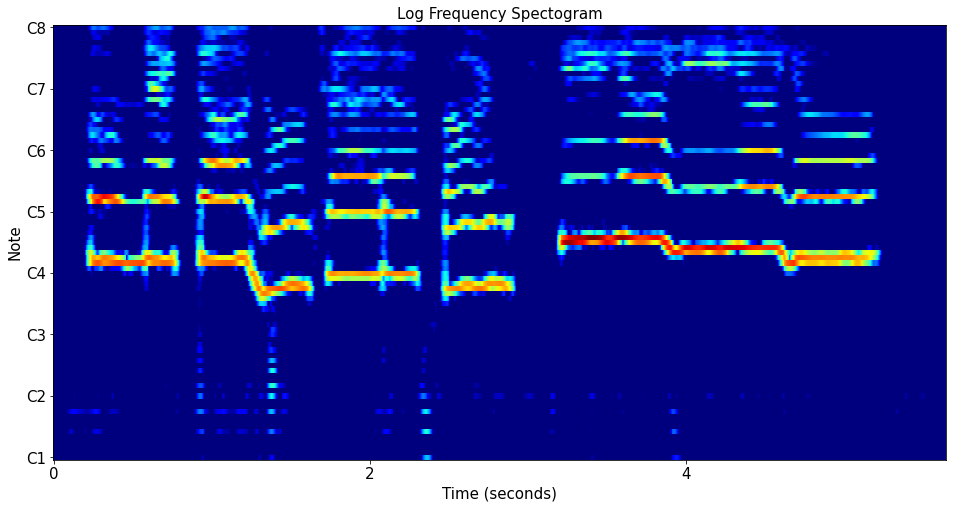

In [68]:
plotLogSpec(Log2, hop_sec, binsPerOctave)

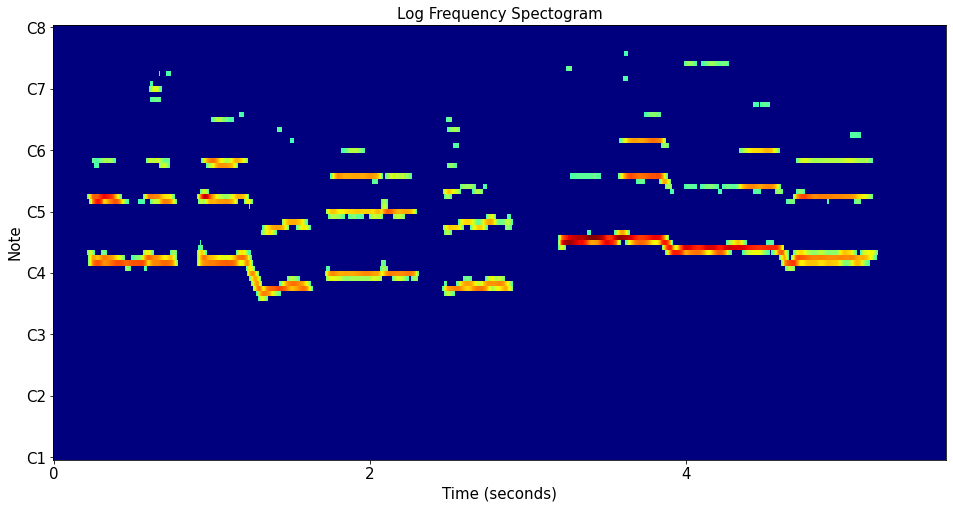

In [69]:
plotLogSpec(Filter2, hop_sec, binsPerOctave)

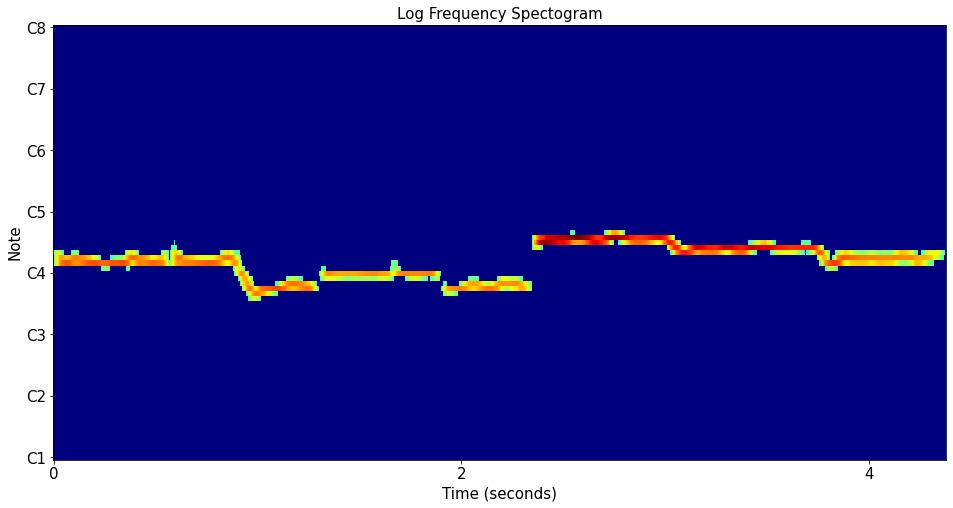

In [70]:
plotLogSpec(FilterCrop2, hop_sec, binsPerOctave)

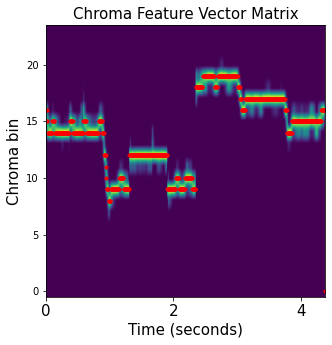

In [71]:
plotChroma(Chroma_norm2, hop_samples, traj = traj_chroma2)

### Match Twinkle Ruth 1 ###

In [72]:
Twinkle_Ruth1, sr = lb.core.load("training/Match Twinkle Ruth 1.m4a")
ipd.Audio(Twinkle_Ruth1, rate = sr)

In [73]:
Log3, Filter3, FilterCrop3, Chroma_norm3, traj_chroma3 = computeChroma(Twinkle_Ruth1, sr, fft_size, hop_samples, f_ref, R, 24)

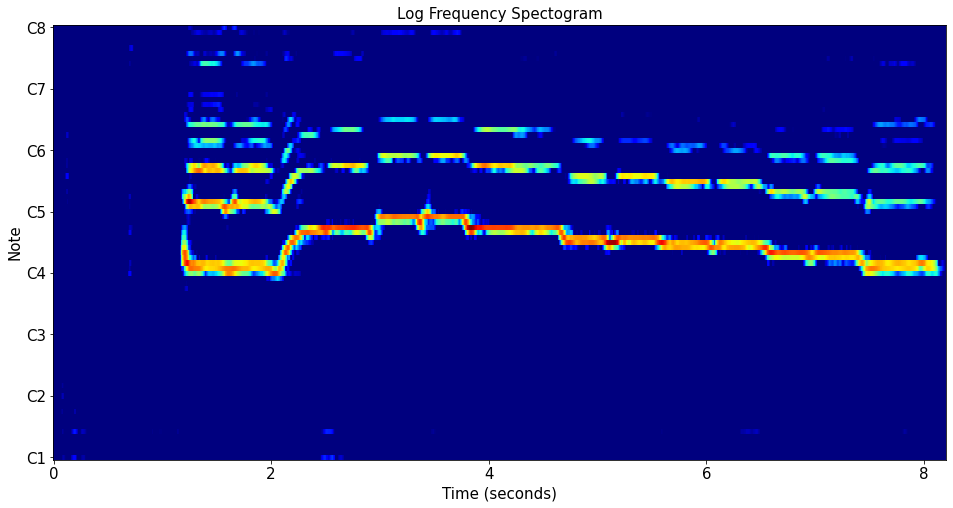

In [74]:
plotLogSpec(Log3, hop_sec, binsPerOctave)

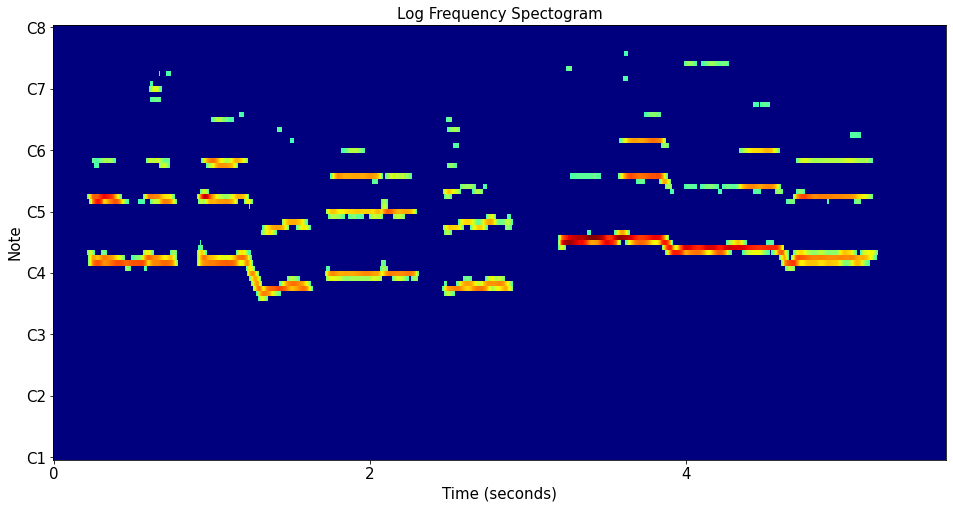

In [75]:
plotLogSpec(Filter2, hop_sec, binsPerOctave)

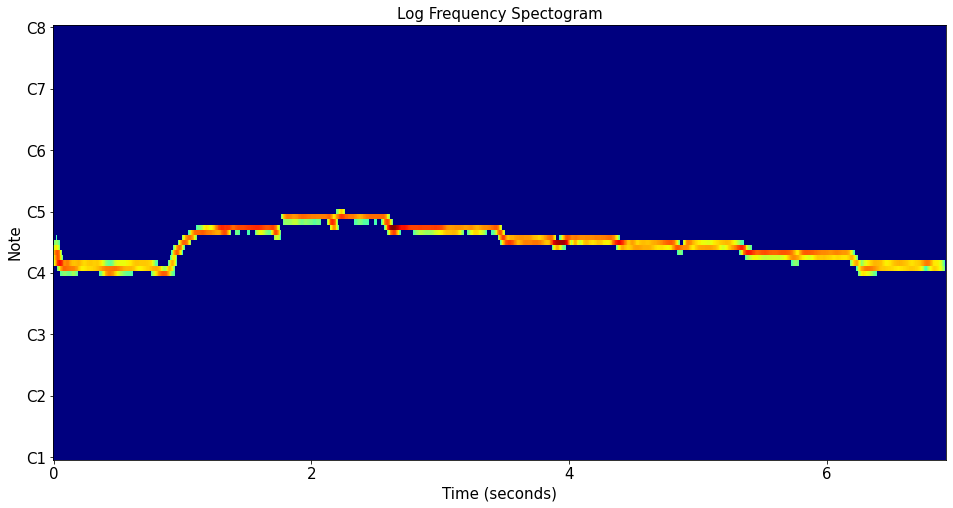

In [76]:
plotLogSpec(FilterCrop3, hop_sec, binsPerOctave)

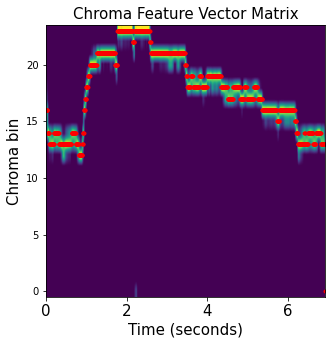

In [77]:
plotChroma(Chroma_norm3, hop_samples, traj = traj_chroma3)

In [78]:
bestcost, besttranspose, alltranspose = DTW(Chroma_norm3, Chroma_norm2, steps, weights_12, 24)

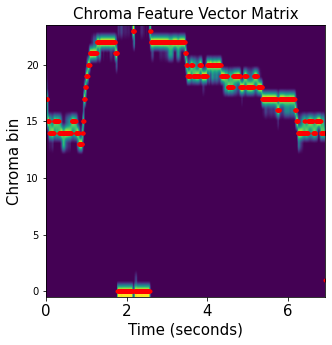

In [80]:
plotChroma(besttranspose, hop_samples, traj = (traj_chroma3 + 1) % 24)

# Processing Data #

In [35]:
refdir = "training/ref"
trainingdir = "training"
querydir = "testing"

### Four Notes -- 1 octave chroma, using weights [1,2] = 1 ###

Using "Match FourNotes Cat 2", "Match FourNotes Ruth 5", "Match FourNotes_Cat_0" as references

In [36]:
Four_labels = generateLabels(trainingdir, "Match FourNotes")

In [49]:
scores_arrFour12, scores_averageFour12, scores_maxFour12 =  calculateScores(refdir, trainingdir, steps, weights_12, fft_size, 12)

123.24475678096044 query: training\FourNotes Cat Jump.m4a
143.54552957312035 query: training\FourNotes Ruth 1.m4a
62.16838750660457 query: training\FourNotes Ruth 3.m4a
109.58504489427897 query: training\Match Brother John Ruth 1.m4a
42.47575927923039 query: training\Match FourNotes Cat 11.m4a
63.661067160384135 query: training\Match FourNotes Cat 3.m4a
85.54284800151477 query: training\Match FourNotes Cat 4.m4a
75.19305244799473 query: training\Match FourNotes Cat 7.m4a
46.65102528381826 query: training\Match FourNotes Cat 9.m4a
66.4958125236258 query: training\Match FourNotes Ruth (longer first note).m4a
48.70841564572771 query: training\Match FourNotes Ruth Hmm.m4a
49.03007480800119 query: training\Match FourNotes Ruth same tempo variance.m4a
59.351778810998496 query: training\Match FourNotes Ruth Silence.m4a
54.87631327777887 query: training\Match FourNotes_Cat_2.m4a
63.28862834065352 query: training\Match FourNotes_Cat_4.m4a
73.42985409202124 query: training\Match FourNotes_Cat_6.

259.95693806490783 query: training\Match Twinkle Cat 1.m4a
256.2264325026374 query: training\Match Twinkle Cat 3.m4a
248.37197453840088 query: training\Match Twinkle Cat 4.m4a
223.2947718311789 query: training\Match Twinkle Cat 5.m4a
237.44422375922545 query: training\Match Twinkle Cat 7.m4a
264.24131331886986 query: training\Match Twinkle Ruth 1.m4a
241.6241995598595 query: training\Match Twinkle Ruth 3.m4a
209.15015903970493 query: training\MD 1.m4a
202.42363741348169 query: training\MD 3.m4a
220.3958107077333 query: training\MD Ruth 1.m4a
205.19044767972736 query: training\MD Ruth 2.m4a
225.18845690646523 query: training\Nonmatch FourNotes Cat 0.m4a
255.0905956349313 query: training\Nonmatch FourNotes Cat 1.m4a
223.42755568114896 query: training\Nonmatch FourNotes Cat 2.m4a
249.50058990412222 query: training\Random hum Ruth 1.m4a
231.45844914048237 query: training\Random Hum Ruth 3.m4a
151.80265594726498 query: training\Two notes Ruth La.m4a


No handles with labels found to put in legend.


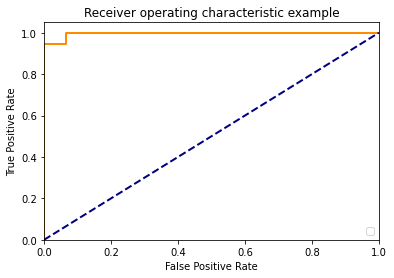

[215.9620382  214.9620382  127.09894664 124.56993874 115.88688464
  59.54826998]


In [50]:
fprfour12, tprfour12, thresholdfour12 = plotROC(Four_labels, scores_averageFour12, pos_label = 0)
print(thresholdfour12)

No handles with labels found to put in legend.


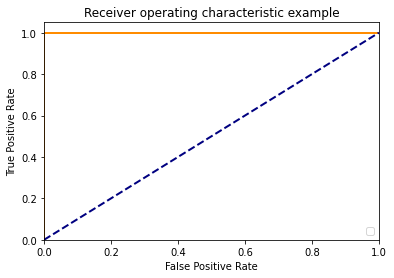

[265.24131332 264.24131332 149.31443641  66.28746545]


In [96]:
fprfour12m, tprfour12m, thresholdfour12m = plotROC(Four_labels, scores_maxFour12, pos_label = 0)
print(thresholdfour12m)

In [51]:
truePosFour12, trueNegFour12, falsePosFour12, falseNegFour12 = runBenchmark(querydir, refdir, weights_12, "Match Four", fprfour12, tprfour12, thresholdfour12, 12, average = True)

127.09894664299706
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Processing 45


C:\Users\cathe\AppData\Local\Continuum\anaconda3\envs\E190\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


118.81820429760887 query: testing\FourNotes Ruth 2.m4a
74.59441082733169 query: testing\FourNotes Ruth Tempo Varied.m4a
69.72442513522084 query: testing\FourNotes_Cat_1.m4a
147.15656494388577 query: testing\Match Ba Ba Black Sheep Ruth 1.m4a
57.903976826038324 query: testing\Match FourNotes Cat 10.m4a
42.52816687529035 query: testing\Match FourNotes Cat 12.m4a
69.73818294196121 query: testing\Match FourNotes Cat 13.m4a
64.0208664017565 query: testing\Match FourNotes Cat 8.m4a
73.62713734287321 query: testing\Match FourNotes Ruth 4.m4a
58.528547732614946 query: testing\Match FourNotes Tony 0.m4a
41.45519141048077 query: testing\Match FourNotes Tsion.m4a
109.08213968429634 query: testing\Match FourNotes_Cat_3.m4a
59.56723515121806 query: testing\Match FourNotes_Cat_5.m4a
58.00450181002869 query: testing\Match FourNotes_Jian.m4a
130.0691480857729 query: testing\Match Jack and Jill Ruth 1.m4a
131.45219282135363 query: testing\Match Little Teapot Ruth 1.m4a
159.92024308939915 query: testing

In [52]:
print(truePosFour12, trueNegFour12, falsePosFour12, falseNegFour12)

10.000000001 32.000000001000004 3 0


In [53]:
accFour12, f1Four12, fprFour12, fnrFour12 = calcRates(truePosFour12, trueNegFour12, falsePosFour12, falseNegFour12)
print(accFour12, f1Four12, fprFour12, fnrFour12)

0.9333333333362963 0.8695652174026465 0.08571428571183673 0.0


#### Using maximum cost to determine threshold as opposed to average

In [101]:
truePosFour12m, trueNegFour12m, falsePosFour12m, falseNegFour12m = runBenchmark(querydir, refdir, weights_12, "Match Four", fprfour12m, tprfour12m, thresholdfour12m, 12, average = True)

149.31443641283914
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Processing 45
118.81820429760887 query: testing\FourNotes Ruth 2.m4a
74.59441082733169 query: testing\FourNotes Ruth Tempo Varied.m4a
69.72442513522084 query: testing\FourNotes_Cat_1.m4a
147.15656494388577 query: testing\Match Ba Ba Black Sheep Ruth 1.m4a
57.903976826038324 query: testing\Match FourNotes Cat 10.m4a
42.52816687529035 query: testing\Match FourNotes Cat 12.m4a
69.73818294196121 query: testing\Match FourNotes Cat 13.m4a
64.0208664017565 query: testing\Match FourNotes Cat 8.m4a
73.62713734287321 query: testing\Match FourNotes Ruth 4.m4a
58.528547732614946 query: testing\Match FourNotes Tony 0.m4a
41.45519141048077 query: testing\Match FourNotes Tsion.m4a
109.08213968429634 query: testing\Match FourNotes_Cat_3.m4a
59.56723515121806 query: testing\Match FourNotes_Cat_5.m4a
58.00450181002869 query: testing\Match FourNotes_Ji

In [102]:
calcRates(truePosFour12m, trueNegFour12m, falsePosFour12m, falseNegFour12m)

(0.8666666666725926, 0.7692307692485207, 0.17142857142367346, 0.0)

Lower accuracy using maximum cost to determine threshold -- us average cost on future experiments

### Four Notes -- 1 octave chroma, using weights [1,2] = 2

In [87]:
scores_arrFour12w, scores_averageFour12w, scores_maxFour12w =  calculateScores(refdir, trainingdir, steps, weights_24, fft_size, 12)

C:\Users\cathe\AppData\Local\Continuum\anaconda3\envs\E190\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


389.74531040771853 query: training\FourNotes Cat Jump.m4a
382.8220647679879 query: training\FourNotes Ruth 1.m4a
523.2301916542606 query: training\FourNotes Ruth 3.m4a
437.4759562042337 query: training\Match Brother John Ruth 1.m4a
517.8061825367181 query: training\Match FourNotes Cat 11.m4a
357.29538626125264 query: training\Match FourNotes Cat 2.m4a
491.4173724792903 query: training\Match FourNotes Cat 3.m4a
408.51154621456357 query: training\Match FourNotes Cat 4.m4a
559.0558167716807 query: training\Match FourNotes Cat 7.m4a
399.99499039762264 query: training\Match FourNotes Cat 9.m4a
402.69563194123424 query: training\Match FourNotes Ruth (longer first note).m4a
466.1314778344893 query: training\Match FourNotes Ruth 5.m4a
333.7296767604596 query: training\Match FourNotes Ruth Hmm.m4a
306.5865300129393 query: training\Match FourNotes Ruth same tempo variance.m4a
316.52459013675787 query: training\Match FourNotes Ruth Silence.m4a
476.10794301833926 query: training\Match FourNotes_Ca

456.3353850736319 query: training\Match Twinkle Cat 1.m4a
393.6417059375492 query: training\Match Twinkle Cat 3.m4a
490.51535150069213 query: training\Match Twinkle Cat 4.m4a
328.375454320853 query: training\Match Twinkle Cat 5.m4a
431.8719902896239 query: training\Match Twinkle Cat 7.m4a
546.900007218432 query: training\Match Twinkle Ruth 1.m4a
413.43309473412774 query: training\Match Twinkle Ruth 3.m4a
650.6240797432712 query: training\MD 1.m4a
398.3264937665242 query: training\MD 3.m4a
621.0520249934418 query: training\MD Ruth 1.m4a
400.83193724924575 query: training\MD Ruth 2.m4a
619.8584202153216 query: training\Nonmatch FourNotes Cat 0.m4a
717.3358329789808 query: training\Nonmatch FourNotes Cat 1.m4a
687.5265725558181 query: training\Nonmatch FourNotes Cat 2.m4a
655.141355742597 query: training\Random hum Ruth 1.m4a
495.98534953424655 query: training\Random Hum Ruth 3.m4a
388.9577984985509 query: training\Two notes Ruth La.m4a


No handles with labels found to put in legend.


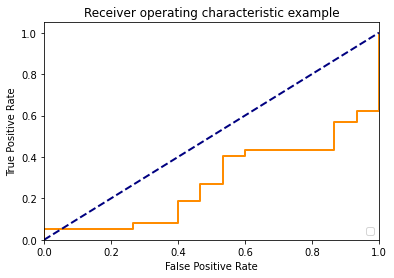

[623.15280362 622.15280362 621.04089662 602.93450384 592.06269587
 586.75666302 572.64941915 569.7940014  554.03156859 550.2858615
 491.82790267 474.48596515 469.4602281  436.77932903 379.38220312
 369.0188912  358.1720259  351.34283423 215.02376542]


In [88]:
fprfour12w, tprfour12w, thresholdfour12w = plotROC(Four_labels, scores_averageFour12w, pos_label = 0)
print(thresholdfour12w)

Really bad ROC curve -- decide against increasing weights

### FourNotes -- 2 octave chroma, [1,2] = 1

In [45]:
scores_arrFourw, scores_averageFourw, scores_maxFourw =  calculateScores(refdir, trainingdir, steps, weights_12, fft_size, 24)

147.41389337255458 query: training\FourNotes Cat Jump.m4a
166.00229799900964 query: training\FourNotes Ruth 1.m4a
62.16838750660455 query: training\FourNotes Ruth 3.m4a
109.7423648235961 query: training\Match Brother John Ruth 1.m4a
42.47575927923039 query: training\Match FourNotes Cat 11.m4a
63.661067160384135 query: training\Match FourNotes Cat 3.m4a
104.49759334123961 query: training\Match FourNotes Cat 4.m4a
77.00011449567859 query: training\Match FourNotes Cat 7.m4a
46.65102528381826 query: training\Match FourNotes Cat 9.m4a
66.4958125236258 query: training\Match FourNotes Ruth (longer first note).m4a
49.551191904208395 query: training\Match FourNotes Ruth Hmm.m4a
57.50025707892181 query: training\Match FourNotes Ruth same tempo variance.m4a
61.06205344133842 query: training\Match FourNotes Ruth Silence.m4a
54.87631327777887 query: training\Match FourNotes_Cat_2.m4a
65.37175572980188 query: training\Match FourNotes_Cat_4.m4a
73.90082955089314 query: training\Match FourNotes_Cat_6.

291.7235583351529 query: training\Match Twinkle Cat 1.m4a
269.7160633078342 query: training\Match Twinkle Cat 3.m4a
282.0664704693444 query: training\Match Twinkle Cat 4.m4a
244.9511330836961 query: training\Match Twinkle Cat 5.m4a
247.9012010494634 query: training\Match Twinkle Cat 7.m4a
266.3962435519927 query: training\Match Twinkle Ruth 1.m4a
244.1190072147887 query: training\Match Twinkle Ruth 3.m4a
209.15015903970493 query: training\MD 1.m4a
202.42363741348169 query: training\MD 3.m4a
220.3958107077333 query: training\MD Ruth 1.m4a
206.02080998406583 query: training\MD Ruth 2.m4a
323.0872102837195 query: training\Nonmatch FourNotes Cat 0.m4a
255.0905956349313 query: training\Nonmatch FourNotes Cat 1.m4a
226.31519869960806 query: training\Nonmatch FourNotes Cat 2.m4a
249.5020467940863 query: training\Random hum Ruth 1.m4a
232.63789635245425 query: training\Random Hum Ruth 3.m4a
154.60003301874772 query: training\Two notes Ruth La.m4a


No handles with labels found to put in legend.


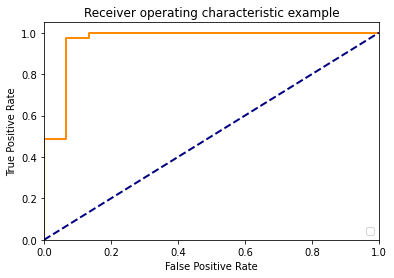

[262.88842381 261.88842381 191.45716035 189.91235765 123.29982192
 120.77080816 115.88688464  65.37171746]


In [46]:
fprfourw, tprfourw, thresholdfourw = plotROC(Four_labels, scores_averageFourw, pos_label = 0)
print(thresholdfourw)

In [47]:
truePosFourw, trueNegFourw, falsePosFourw, falseNegFourw = runBenchmark(querydir, refdir, weights_12, "Match Four", fprfourw, tprfourw, thresholdfourw, 24, average = True)

123.29982192139734
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Processing 45


C:\Users\cathe\AppData\Local\Continuum\anaconda3\envs\E190\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


118.81820429760887 query: testing\FourNotes Ruth 2.m4a
74.59441082733169 query: testing\FourNotes Ruth Tempo Varied.m4a
70.93870703844505 query: testing\FourNotes_Cat_1.m4a
150.99470622314055 query: testing\Match Ba Ba Black Sheep Ruth 1.m4a
60.39515976162247 query: testing\Match FourNotes Cat 10.m4a
42.52816687529035 query: testing\Match FourNotes Cat 12.m4a
69.73818294196121 query: testing\Match FourNotes Cat 13.m4a
66.9847411349005 query: testing\Match FourNotes Cat 8.m4a
80.33804718435096 query: testing\Match FourNotes Ruth 4.m4a
86.50909110373918 query: testing\Match FourNotes Tony 0.m4a
41.45519141048077 query: testing\Match FourNotes Tsion.m4a
109.08213968429634 query: testing\Match FourNotes_Cat_3.m4a
60.0075493832672 query: testing\Match FourNotes_Cat_5.m4a
58.488159730379316 query: testing\Match FourNotes_Jian.m4a
130.0691480857729 query: testing\Match Jack and Jill Ruth 1.m4a
153.95948251117125 query: testing\Match Little Teapot Ruth 1.m4a
160.84290162671726 query: testing\M

In [139]:
print(truePosFourw, trueNegFourw, falsePosFourw, falseNegFourw)

10.000000001 32.000000001000004 3 0


In [48]:
calcRates(truePosFourw, trueNegFourw, falsePosFourw, falseNegFourw)

(0.9333333333362963, 0.8695652174026465, 0.08571428571183673, 0.0)

### Four Notes -- 2 octave chroma, Transition weight of 2 ###

Same references as above

In [90]:
scores_arrFour, scores_averageFour, scores_maxFour =  calculateScores(refdir, trainingdir, steps, weights_24, fft_size, 24)

459.275351063767 query: training\FourNotes Cat Jump.m4a
448.7360790565327 query: training\FourNotes Ruth 1.m4a
523.3520757407722 query: training\FourNotes Ruth 3.m4a
441.09251649513845 query: training\Match Brother John Ruth 1.m4a
517.8061825367181 query: training\Match FourNotes Cat 11.m4a
391.89637343076345 query: training\Match FourNotes Cat 2.m4a
491.4173724792903 query: training\Match FourNotes Cat 3.m4a
440.0087620748207 query: training\Match FourNotes Cat 4.m4a
563.7204495631374 query: training\Match FourNotes Cat 7.m4a
425.00267495566374 query: training\Match FourNotes Cat 9.m4a
402.7745806349904 query: training\Match FourNotes Ruth (longer first note).m4a
466.1314778344893 query: training\Match FourNotes Ruth 5.m4a
334.00794145234784 query: training\Match FourNotes Ruth Hmm.m4a
362.82285906510526 query: training\Match FourNotes Ruth same tempo variance.m4a
319.4107080689326 query: training\Match FourNotes Ruth Silence.m4a
479.74234887814305 query: training\Match FourNotes_Cat_

625.3549160056792 query: training\Match Twinkle Cat 1.m4a
585.9464857431435 query: training\Match Twinkle Cat 3.m4a
620.7040704575561 query: training\Match Twinkle Cat 4.m4a
589.4774459956126 query: training\Match Twinkle Cat 5.m4a
550.3443669136523 query: training\Match Twinkle Cat 7.m4a
663.5574714606629 query: training\Match Twinkle Ruth 1.m4a
413.43309473412774 query: training\Match Twinkle Ruth 3.m4a
731.6943080250135 query: training\MD 1.m4a
398.3264937665242 query: training\MD 3.m4a
621.0520249934418 query: training\MD Ruth 1.m4a
410.6739231609476 query: training\MD Ruth 2.m4a
796.6049904244921 query: training\Nonmatch FourNotes Cat 0.m4a
852.4170393343294 query: training\Nonmatch FourNotes Cat 1.m4a
699.2218407170824 query: training\Nonmatch FourNotes Cat 2.m4a
708.8339231362097 query: training\Random hum Ruth 1.m4a
495.98534953424655 query: training\Random Hum Ruth 3.m4a
395.3222977526445 query: training\Two notes Ruth La.m4a


No handles with labels found to put in legend.


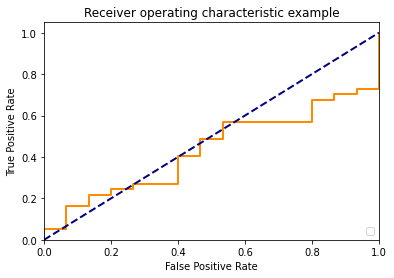

[771.5840351  770.5840351  710.75987214 678.15837161 629.74587954
 622.67734971 621.00654456 614.01822705 606.36833637 604.18085741
 598.00534879 590.34578066 572.39780256 570.36523111 557.24349002
 550.2858615  515.16937074 471.44444945 443.24465911 436.83859604
 435.77280263 369.11639272 367.79172043 357.88078681 217.57876197]


In [91]:
fprfour, tprfour, thresholdfour = plotROC(Four_labels, scores_averageFour, pos_label = 0)
print(thresholdfour)

Again, really bad ROC graph

### Old McDonalds -- 12 Chroma, [1,2] weight 1 ###

Using "Match MD Cat 1", "Match MD Ruth 1", and "Match MD Tsion Hmm" as references.

In [70]:
MD_labels = generateLabels(trainingdir, "Match MD")
print(MD_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [41]:
scores_arrMD12, scores_averageMD12, scores_maxMD12 =  calculateScores(refdir, trainingdir, steps, weights_12, fft_size, 12)

C:\Users\cathe\AppData\Local\Continuum\anaconda3\envs\E190\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


232.77806118843674 query: training\FourNotes Cat Jump.m4a
213.59892623873796 query: training\FourNotes Ruth 1.m4a
259.05607682653704 query: training\FourNotes Ruth 3.m4a
251.8573649515187 query: training\Match Brother John Ruth 1.m4a
269.8047663902271 query: training\Match FourNotes Cat 11.m4a
184.339979157067 query: training\Match FourNotes Cat 2.m4a
273.1108795110164 query: training\Match FourNotes Cat 3.m4a
226.043232889902 query: training\Match FourNotes Cat 4.m4a
308.6077817667408 query: training\Match FourNotes Cat 7.m4a
195.32205422214187 query: training\Match FourNotes Cat 9.m4a
214.4049682480872 query: training\Match FourNotes Ruth (longer first note).m4a
282.49280798633225 query: training\Match FourNotes Ruth 5.m4a
173.7424064384258 query: training\Match FourNotes Ruth Hmm.m4a
223.38262904644535 query: training\Match FourNotes Ruth same tempo variance.m4a
170.93368776908244 query: training\Match FourNotes Ruth Silence.m4a
272.8220674823539 query: training\Match FourNotes_Cat_

286.79640150557964 query: training\Match MD Tony 0.m4a
225.45481260443287 query: training\Match Twinkle Cat 1.m4a
233.74219793569068 query: training\Match Twinkle Cat 3.m4a
219.7145947522938 query: training\Match Twinkle Cat 4.m4a
169.98175023624066 query: training\Match Twinkle Cat 5.m4a
222.05682220625872 query: training\Match Twinkle Cat 7.m4a
233.47144429977774 query: training\Match Twinkle Ruth 1.m4a
212.16425828013348 query: training\Match Twinkle Ruth 3.m4a
346.1643417130108 query: training\MD 1.m4a
236.59531576872754 query: training\MD 3.m4a
331.22549608669664 query: training\MD Ruth 1.m4a
207.31523288582187 query: training\MD Ruth 2.m4a
327.209839317768 query: training\Nonmatch FourNotes Cat 0.m4a
391.78546823410113 query: training\Nonmatch FourNotes Cat 1.m4a
341.2536869017942 query: training\Nonmatch FourNotes Cat 2.m4a
351.1528280305663 query: training\Random hum Ruth 1.m4a
266.37166382869793 query: training\Random Hum Ruth 3.m4a
203.006160711899 query: training\Two notes R

No handles with labels found to put in legend.


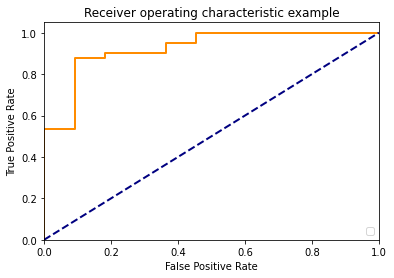

[408.51151538 407.51151538 314.75600508 309.52021161 232.57781031
 232.38218859 227.61191848 223.70312427 207.30552285 203.11755739
 191.6253843  133.53401071]


In [93]:
fprMD12, tprMD12, thresholdMD12 = plotROC(MD_labels, scores_averageMD12, pos_label = 0)
print(thresholdMD12)

In [45]:
truePosMD12, trueNegMD12, falsePosMD12, falseNegMD12 = runBenchmark(querydir, refdir, weights_12, "Match MD", fprMD12, tprMD12, thresholdMD12, 12, average = True)

206.71852301894293
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Processing 45


C:\Users\cathe\AppData\Local\Continuum\anaconda3\envs\E190\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


237.11988655274865 query: testing\FourNotes Ruth 2.m4a
204.27726674423644 query: testing\FourNotes Ruth Tempo Varied.m4a
254.9196259898569 query: testing\FourNotes_Cat_1.m4a
155.0556736875355 query: testing\Match Ba Ba Black Sheep Ruth 1.m4a
271.98068692328616 query: testing\Match FourNotes Cat 10.m4a
248.14518449918256 query: testing\Match FourNotes Cat 12.m4a
183.33549334573198 query: testing\Match FourNotes Cat 13.m4a
307.3926893545559 query: testing\Match FourNotes Cat 8.m4a
255.94174611349777 query: testing\Match FourNotes Ruth 4.m4a
254.5650275958317 query: testing\Match FourNotes Tony 0.m4a
195.49755089121038 query: testing\Match FourNotes Tsion.m4a
318.08230466963977 query: testing\Match FourNotes_Cat_3.m4a
287.1801360703485 query: testing\Match FourNotes_Cat_5.m4a
209.23656330602032 query: testing\Match FourNotes_Jian.m4a
241.44496829869888 query: testing\Match Jack and Jill Ruth 1.m4a
189.22785143235 query: testing\Match Little Teapot Ruth 1.m4a
124.49191770542816 query: test

In [46]:
print(truePosMD12, trueNegMD12, falsePosMD12, falseNegMD12)

9.000000001 29.000000001 7 0


In [47]:
calcRates(truePosMD12, trueNegMD12, falsePosMD12, falseNegMD12)

(0.844444444451358, 0.7200000000223999, 0.19444444443904318, 0.0)

### Old McDonalds --  24 Chroma, [1,2] = 1 ###

Same references as above

In [45]:
scores_arrMD, scores_averageMD, scores_maxMD =  calculateScores(refdir, trainingdir, steps, weights_12, fft_size, 24)

263.6034757145844 query: training\FourNotes Cat Jump.m4a
217.2712732553818 query: training\FourNotes Ruth 1.m4a
278.899382167078 query: training\FourNotes Ruth 3.m4a
252.22505678462525 query: training\Match Brother John Ruth 1.m4a
269.8047663902271 query: training\Match FourNotes Cat 11.m4a
206.46283836642942 query: training\Match FourNotes Cat 2.m4a
273.4175491188497 query: training\Match FourNotes Cat 3.m4a
226.14116322941916 query: training\Match FourNotes Cat 4.m4a
310.34248160964205 query: training\Match FourNotes Cat 7.m4a
198.72749925054848 query: training\Match FourNotes Cat 9.m4a
214.4049682480872 query: training\Match FourNotes Ruth (longer first note).m4a
284.6405673191619 query: training\Match FourNotes Ruth 5.m4a
173.74941532362323 query: training\Match FourNotes Ruth Hmm.m4a
223.38262904644535 query: training\Match FourNotes Ruth same tempo variance.m4a
170.93368776908244 query: training\Match FourNotes Ruth Silence.m4a
273.4688262988045 query: training\Match FourNotes_Ca

360.5787340995592 query: training\Match MD Tony 0.m4a
331.2387301869661 query: training\Match Twinkle Cat 1.m4a
311.77284976774064 query: training\Match Twinkle Cat 3.m4a
308.4774483679033 query: training\Match Twinkle Cat 4.m4a
288.93848258758527 query: training\Match Twinkle Cat 5.m4a
230.84724958290136 query: training\Match Twinkle Cat 7.m4a
327.28112072858784 query: training\Match Twinkle Ruth 1.m4a
292.8847470361801 query: training\Match Twinkle Ruth 3.m4a
353.8996045935397 query: training\MD 1.m4a
236.59531576872754 query: training\MD 3.m4a
338.87400802732907 query: training\MD Ruth 1.m4a
211.6626186084341 query: training\MD Ruth 2.m4a
398.12195599160015 query: training\Nonmatch FourNotes Cat 0.m4a
414.0759909582261 query: training\Nonmatch FourNotes Cat 1.m4a
428.7899747038195 query: training\Nonmatch FourNotes Cat 2.m4a
386.8329033980169 query: training\Random hum Ruth 1.m4a
267.87881213322066 query: training\Random Hum Ruth 3.m4a
203.006160711899 query: training\Two notes Ruth

No handles with labels found to put in legend.


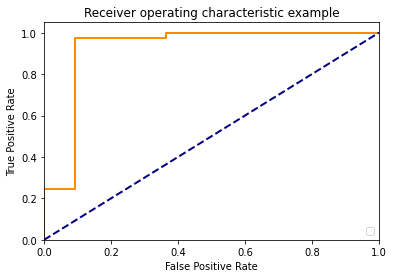

[394.386452   393.386452   329.61023812 329.11639606 203.36168305
 165.78070708 155.40513133 116.534901  ]


In [46]:
fprMD, tprMD, thresholdMD = plotROC(MD_labels, scores_averageMD, pos_label = 0)
print(thresholdMD)

In [48]:
truePosMD, trueNegMD, falsePosMD, falseNegMD = runBenchmark(querydir, refdir, weights_12, "Match MD", fprMD, tprMD, thresholdMD, 24, average = True)

203.36168304855815
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Processing 45


C:\Users\cathe\AppData\Local\Continuum\anaconda3\envs\E190\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


217.93024640178317 query: testing\FourNotes Ruth 2.m4a
209.42803004058192 query: testing\FourNotes Ruth Tempo Varied.m4a
248.89413440269263 query: testing\FourNotes_Cat_1.m4a
224.32932618598645 query: testing\Match Ba Ba Black Sheep Ruth 1.m4a
271.6348903872862 query: testing\Match FourNotes Cat 10.m4a
253.63078775058372 query: testing\Match FourNotes Cat 12.m4a
193.97081798619976 query: testing\Match FourNotes Cat 13.m4a
329.0927866638379 query: testing\Match FourNotes Cat 8.m4a
266.7063166261979 query: testing\Match FourNotes Ruth 4.m4a
275.6910139187205 query: testing\Match FourNotes Tony 0.m4a
223.5997554777051 query: testing\Match FourNotes Tsion.m4a
300.340215515445 query: testing\Match FourNotes_Cat_3.m4a
294.78642572441714 query: testing\Match FourNotes_Cat_5.m4a
250.1741846667337 query: testing\Match FourNotes_Jian.m4a
287.1721648608825 query: testing\Match Jack and Jill Ruth 1.m4a
262.9219416957589 query: testing\Match Little Teapot Ruth 1.m4a
119.88672828986478 query: testin

In [49]:
print(truePosMD, trueNegMD, falsePosMD, falseNegMD)

9.000000001 35.000000001000004 1 0


In [73]:
calcRates(truePosMD, trueNegMD, falsePosMD, falseNegMD)

(0.9777777777787654, 0.9473684210581718, 0.02777777777700617, 0.0)

### Old McDonalds -- Log Freq Energy (ran on only one reference and less queries, we were running out of time)

In [67]:
scores_arrLogMD, scores_averageLogMD, scores_maxLogMD =  calculateScores(refdir, trainingdir, steps, weights_12, fft_size, 24, CQT = False, Energy = True)

C:\Users\cathe\AppData\Local\Continuum\anaconda3\envs\E190\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


267.1767922045568 query: training\FourNotes Cat Jump.m4a
217.2712732553818 query: training\FourNotes Ruth 1.m4a
279.3083128664024 query: training\FourNotes Ruth 3.m4a
252.22505678462525 query: training\Match Brother John Ruth 1.m4a
274.5954762080245 query: training\Match FourNotes Cat 11.m4a
212.99546135722866 query: training\Match FourNotes Cat 2.m4a
273.483318009769 query: training\Match FourNotes Cat 3.m4a
226.14116322941916 query: training\Match FourNotes Cat 4.m4a
310.34248160964205 query: training\Match FourNotes Cat 7.m4a
205.94136578150653 query: training\Match FourNotes Cat 9.m4a
305.87059121933095 query: training\Match FourNotes Piano 0.m4a
318.17129068982894 query: training\Match FourNotes Piano 1.m4a
215.41000674240945 query: training\Match FourNotes Ruth (longer first note).m4a
285.05510522237313 query: training\Match FourNotes Ruth 5.m4a
181.33063447324452 query: training\Match FourNotes Ruth Hmm.m4a
229.44963159845372 query: training\Match FourNotes Ruth same tempo varia

No handles with labels found to put in legend.


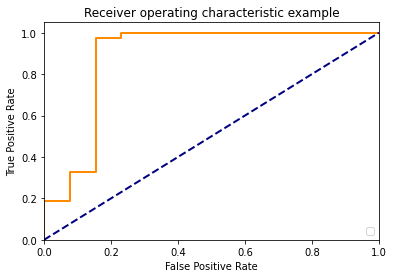

[364.63339641 363.63339641 305.87059122 297.24388767 273.991745
 273.63463713 176.28739177 165.53908245 156.08725781 100.14992673]


In [71]:
fprLogMD, tprLogMD, thresholdLogMD = plotROC(MD_labels, scores_averageLogMD, pos_label = 0)
print(thresholdLogMD)

Unable to determine a suitable threshold

### Old McDonalds -- CQT Energy (ran on only one reference and less queries, we were running out of time)

In [72]:
scores_arrCQTEMD, scores_averageCQTEMD, scores_maxCQTEMD =  calculateScores(refdir, trainingdir, steps, weights_12, fft_size, 24, CQT = True, Energy = True)

C:\Users\cathe\AppData\Local\Continuum\anaconda3\envs\E190\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


287.48158141814 query: training\FourNotes Cat Jump.m4a
183.94673954611878 query: training\FourNotes Ruth 1.m4a
294.18737374830835 query: training\FourNotes Ruth 3.m4a
262.98009010894486 query: training\Match Brother John Ruth 1.m4a
259.4631344512224 query: training\Match FourNotes Cat 11.m4a
247.61989659442017 query: training\Match FourNotes Cat 2.m4a
235.10440808282655 query: training\Match FourNotes Cat 3.m4a
277.3034126748326 query: training\Match FourNotes Cat 4.m4a
395.10880912689953 query: training\Match FourNotes Cat 7.m4a
233.5280397040435 query: training\Match FourNotes Cat 9.m4a
276.627919373011 query: training\Match FourNotes Piano 0.m4a
310.9824004297261 query: training\Match FourNotes Piano 1.m4a
198.5163333900024 query: training\Match FourNotes Ruth (longer first note).m4a
272.484019304775 query: training\Match FourNotes Ruth 5.m4a
128.34398835030396 query: training\Match FourNotes Ruth Hmm.m4a
240.03419717052554 query: training\Match FourNotes Ruth same tempo variance.m4

No handles with labels found to put in legend.


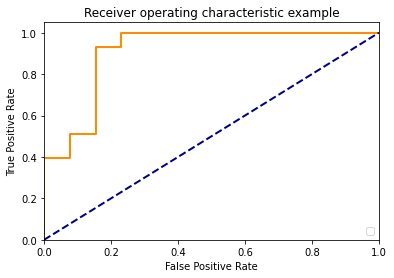

[396.10880913 395.10880913 269.11690043 263.25103692 247.61989659
 245.21569141 153.73166332 140.38244543 109.11963221  52.63187853]


In [74]:
fprCQTEMD, tprCQTEMD, thresholdCQTEMD = plotROC(MD_labels, scores_averageCQTEMD, pos_label = 0)
print(thresholdCQTEMD)

Unable to determine a suitable threshold

### Old McDonalds -- CQT ###

In [78]:
scores_arrCQTMD, scores_averageCQTMD, scores_maxCQTMD =  calculateScores(refdir, trainingdir, steps, weights_12, fft_size, 24, CQT = True)

295.18708479092084 query: training\FourNotes Cat Jump.m4a


C:\Users\cathe\AppData\Local\Continuum\anaconda3\envs\E190\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


218.15721429437124 query: training\FourNotes Ruth 1.m4a
285.9710724833241 query: training\FourNotes Ruth 3.m4a
304.9715444319676 query: training\Match Brother John Ruth 1.m4a
274.699294569749 query: training\Match FourNotes Cat 11.m4a
247.39815522138124 query: training\Match FourNotes Cat 2.m4a
290.67465730152617 query: training\Match FourNotes Cat 3.m4a
301.90516652335447 query: training\Match FourNotes Cat 4.m4a
376.3175731901653 query: training\Match FourNotes Cat 7.m4a
244.28488021712224 query: training\Match FourNotes Cat 9.m4a
205.42981322035885 query: training\Match FourNotes Ruth (longer first note).m4a
284.9903911963192 query: training\Match FourNotes Ruth 5.m4a
174.24782330161312 query: training\Match FourNotes Ruth Hmm.m4a
180.83214067363141 query: training\Match FourNotes Ruth same tempo variance.m4a
148.75517216969072 query: training\Match FourNotes Ruth Silence.m4a
283.8100560494241 query: training\Match FourNotes_Cat_0.m4a
316.4287117126973 query: training\Match FourNote

374.1591476612009 query: training\Match Twinkle Cat 4.m4a
326.50492147614176 query: training\Match Twinkle Cat 5.m4a
297.9880581799974 query: training\Match Twinkle Cat 7.m4a
412.6843721506958 query: training\Match Twinkle Ruth 1.m4a
Error
360.876997597103 query: training\MD 1.m4a
274.78917862090987 query: training\MD 3.m4a
365.236331159652 query: training\MD Ruth 1.m4a
206.572204116968 query: training\MD Ruth 2.m4a
398.2826689023666 query: training\Nonmatch FourNotes Cat 0.m4a
426.8103845840484 query: training\Nonmatch FourNotes Cat 1.m4a
398.24742474424534 query: training\Nonmatch FourNotes Cat 2.m4a
330.7714077850824 query: training\Random hum Ruth 1.m4a
241.72068115509103 query: training\Random Hum Ruth 3.m4a
296.54684793449013 query: training\Two notes Ruth La.m4a


No handles with labels found to put in legend.


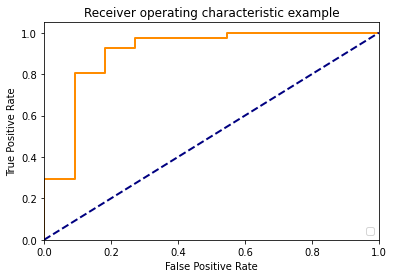

[400.98690503 399.98690503 314.36244444 313.7533874  211.18555148
 201.65177561 197.11704082 179.62081528 176.9942579  120.31448045]


In [79]:
fprCQTMD, tprCQTMD, thresholdCQTMD = plotROC(MD_labels, scores_averageCQTMD, pos_label = 0)
print(thresholdCQTMD)

In [80]:
truePosCQTMD, trueNegCQTMD, falsePosCQTMD, falseNegCQTMD = runBenchmark(querydir, refdir, weights_12, "Match MD", fprCQTMD, tprCQTMD, thresholdCQTMD, 24, average = True)

270.9243970212979
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Processing 45


C:\Users\cathe\AppData\Local\Continuum\anaconda3\envs\E190\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


240.46088027428073 query: testing\FourNotes Ruth 2.m4a
211.1820736613278 query: testing\FourNotes Ruth Tempo Varied.m4a
257.62453416111543 query: testing\FourNotes_Cat_1.m4a
242.84788725613916 query: testing\Match Ba Ba Black Sheep Ruth 1.m4a
304.84767706517715 query: testing\Match FourNotes Cat 10.m4a
248.14518449918256 query: testing\Match FourNotes Cat 12.m4a
183.33549334573198 query: testing\Match FourNotes Cat 13.m4a
312.2447449333608 query: testing\Match FourNotes Cat 8.m4a
255.94174611349777 query: testing\Match FourNotes Ruth 4.m4a
274.9719370536462 query: testing\Match FourNotes Tony 0.m4a
212.45410250941103 query: testing\Match FourNotes Tsion.m4a
318.08230466963977 query: testing\Match FourNotes_Cat_3.m4a
287.1801360703485 query: testing\Match FourNotes_Cat_5.m4a
230.8476705817594 query: testing\Match FourNotes_Jian.m4a
271.05292864352475 query: testing\Match Jack and Jill Ruth 1.m4a
264.8422135064229 query: testing\Match Little Teapot Ruth 1.m4a
130.05370324484966 query: te

In [142]:
print(truePosCQTMD, trueNegCQTMD, falsePosCQTMD, falseNegCQTMD)

9.000000001 31.000000001 5 0


In [82]:
calcRates(truePosCQTMD, trueNegCQTMD, falsePosCQTMD, falseNegCQTMD)

(0.8888888888938271, 0.7826086956710775, 0.13888888888503084, 0.0)